[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/08-DWT/DWT_compression.ipynb)

# Image Compression with YCoCg + 2D-DWT

## Parameters

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
import math
import pywt

%matplotlib inline

!ln -sf ~/repos/image_IO/logging_config.py .
!ln -sf ~/repos/image_IO/image_3.py .
import image_3 as RGB_image
!ln -sf ~/repos/image_IO/image_1.py .
import image_1 as gray_image
!ln -sf ~/repos/DWT/DWT.py .
import DWT
!ln -sf ~/information_theory/information.py .
import information
!ln -sf ~/information_theory/distortion.py .
import distortion
#!ln -sf ~/repos/YCoCg/YCoCg.py .
#import YCoCg as YUV
!ln -sf ~/repos/DCT/color_DCT.py .
import color_DCT as YUV
!ln -sf ~/repos/scalar_quantization/quantization.py .
import quantization
!ln -sf ~/repos/scalar_quantization/deadzone_quantization.py .
#import deadzone_quantization as deadzone
from deadzone_quantization import Deadzone_Quantizer as Quantizer


## Configuration

In [2]:
#wavelet_name = "Haar"
wavelet_name = "db3"
#wavelet_name = "db5"
#wavelet_name = "db7"
#wavelet_name = "db15"
#wavelet_name = "bior3.1"
#wavelet_name = "bior3.3"
#wavelet_name = "bior5.5"
wavelet = pywt.Wavelet(wavelet_name)
print(wavelet)

Wavelet db3
  Family name:    Daubechies
  Short name:     db
  Filters length: 6
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [3]:
HOME = os.environ["HOME"]
#test_image = "../sequences/stockholm/"
test_image = HOME + "/repos/MRVC/images/lena_color/"
#test_image = "../images/lena_bw/"

#quantizer = deadzone.Deadzone_Quantizer

#RGB_image.write = RGB_image.debug_write # Faster, but lower compression
#RGB_image.write = information.write # The fastest, but returns only an estimation of the length
#gray_image.write = gray_image.debug_write # Faster, but lower compression
#gray_image.write = information.write # The fastest, but returns only an estimation of the length

In [4]:
N_levels = 5

In [5]:
N_components = 3

## Subband-components information

In [6]:
def info(sbc):
    max = sbc.max()
    min = sbc.min()
    max_min = max - min
    avg = np.average(sbc)
    dev = math.sqrt(np.var(sbc))
    entropy = information.entropy(sbc.flatten().astype(np.int16))
    energy = information.energy(sbc)
    avg_energy = information.energy(sbc)/sbc.size
    shape = sbc.shape
    return max, min, max_min, avg, dev, entropy, energy, avg_energy, shape

def subbands_info(decomp):
    print("sorting subband-components by entropy")
    print("sbc maximum mininum max-min average std-dev entropy        energy  avg-enegy shape")
    list_of_subbands_components = []
    sbc_index = 0
    accumulated_entropy = 0
    max_val = 0
    min_val = 10E10
    for c in range(N_components):
        sbc = decomp[0][..., c]
        infos = info(sbc)
        list_of_subbands_components.append((sbc_index, *infos))
        entropy = infos[5]
        accumulated_entropy += (entropy * sbc.size)
        if max_val < infos[0]:
            max_val = infos[0]
        if min_val > infos[1]:
            min_val = infos[1]
        sbc_index += 1
    for sr in decomp[1:]:
        for sb in sr:
            for c in range(N_components):
                sbc = sb[..., c]
                infos = info(sbc)
                list_of_subbands_components.append((sbc_index, *infos))
                entropy = infos[5]
                accumulated_entropy += (entropy * sbc.size)
                if max_val < infos[0]:
                    max_val = infos[0]
                if min_val > infos[1]:
                    min_val = infos[1]
                sbc_index += 1
    sorted_list_of_subbands_components = sorted(list_of_subbands_components, key=lambda x: x[6])[::-1]
    for _i in sorted_list_of_subbands_components:
        sbc_index, max, min, max_min, avg, dev, entropy, energy, avg_energy, shape = _i
        print(f"{sbc_index:3d} {max:7.1f} {min:7.1f} {max_min:7.1f} {avg:7.1f} {dev:7.1f} {entropy:7.1f} {energy:13.1f} {avg_energy:10.1f} {shape}")

    avg_entropy = accumulated_entropy / img.size
    print("Image path:", test_image)
    print("Wavelet name:", wavelet)
    print("Number of levels:", N_levels)
    print("Number of subbands:", (sbc_index+1)/3)
    print("Number of subband-components:", sbc_index+1)
    print("Average entropy in the wavelet domain:", avg_entropy)
    print("Entropy in the image domain:", information.entropy(img.flatten().astype(np.uint8)))
    print("Maximum coefficient value:", max_val)
    print("Minimum coefficient value:", min_val)
    print("Dynamic range in the transform domain:", max_val - min_val)
    print("Number of bits required for encoding the coefficients using integer numbers:", math.ceil(math.log(max_val - min_val)/math.log(2)))
    
img = RGB_image.read(test_image).astype(np.int16)
YUV_img = YUV.from_RGB(img)
avgs = [np.average(YUV_img[...,c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
decom = DWT.analyze(YUV_img, wavelet, N_levels)
subbands_info(decom)

[image_3.py:42 read() INFO] /home/vruiz/repos/MRVC/images/lena_color/000.png (512, 512, 3) uint8 len=512673 max=255 min=1


avgs=[217.13040549266634, 17.98332955505486, 77.04341443311425]
sorting subband-components by entropy
sbc maximum mininum max-min average std-dev entropy        energy  avg-enegy shape
 15  1528.8 -1266.4  2795.2     3.7   299.3     8.9    91726717.9    89576.9 (32, 32)
 12  1001.6 -1242.7  2244.3    -3.9   160.8     8.1    26500369.1    25879.3 (32, 32)
 24   812.5  -856.0  1668.5     1.7   111.8     8.0    51253262.0    12513.0 (64, 64)
 18  1089.5  -735.4  1824.8     0.1   136.5     8.0    19080315.8    18633.1 (32, 32)
  0  5246.3 -4490.3  9736.6     4.2  1930.8     8.0   954323390.7  3727825.7 (16, 16)
  6  2355.2 -2455.4  4810.6    50.7   901.3     7.9   208606263.9   814868.2 (16, 16)
  1  1036.9 -1764.9  2801.8    31.5   621.4     7.9    99112959.7   387160.0 (16, 16)
  2   766.4  -588.8  1355.2     1.4   289.8     7.8    21500561.6    83986.6 (16, 16)
  3  1747.3 -1239.0  2986.3     0.3   366.8     7.7    34443817.0   134546.2 (16, 16)
  9  1349.2 -1225.9  2575.1    22.1   355

### Comments
1. Most of the energy (and entropy, i.e., information) is concentrated in the low-frequency subbands.
2. The wavelet domain is potentially more compressible than the image domain, because the entropy is smaller.
3. The number of bits required for representing the low-frequency subbands is significantly higher than the original 8-bits/component. This number depends on the wavelet filters, the number of levels of the transform, and the original image.

## Lossless compression

### Using the "glued" representation
Subbands-components use 16 bits/coefficient when they are written in disk.

[image_3.py:42 read() INFO] /home/vruiz/repos/MRVC/images/lena_color/000.png (512, 512, 3) uint8 len=512673 max=255 min=1
[image_3.py:88 print_stats() INFO] component=0 max=255 min=54 avg=180.22401428222656
[image_3.py:88 print_stats() INFO] component=1 max=248 min=1 avg=99.05646133422852
[image_3.py:88 print_stats() INFO] component=2 max=239 min=8 avg=105.41263198852539


avgs=[217.13040549266634, 17.98332955505486, 77.04341443311425]


[image_3.py:55 write() INFO] Before optipng: 753228 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/lossless000.png
[image_3.py:62 write() INFO] /tmp/lossless000.png (512, 512, 3) uint16 len=617117 max=38014 min=28277
[image_3.py:42 read() INFO] /tmp/lossless000.png (512, 512, 3) uint16 len=617117 max=38014 min=28277
[image_3.py:88 print_stats() INFO] component=0 max=255 min=0 avg=179.67313766479492
[image_3.py:88 print_stats() INFO] component=1 max=248 min=1 avg=98.5556411743164
[image_3.py:88 print_stats() INFO] component=2 max=239 min=7 avg=104.91154479980469


output_length=617117


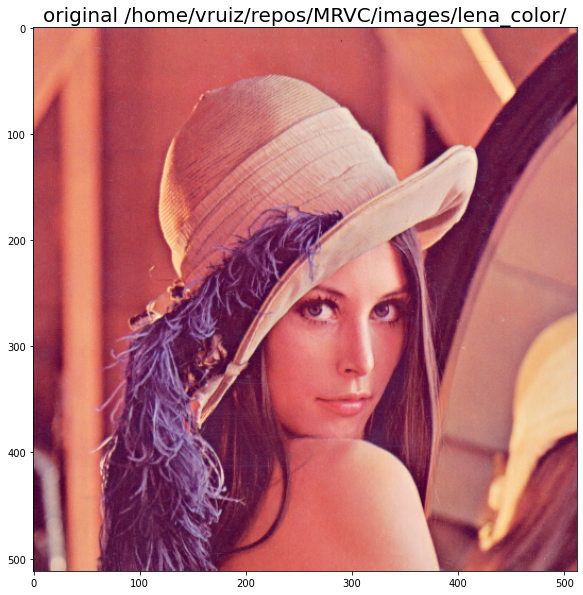

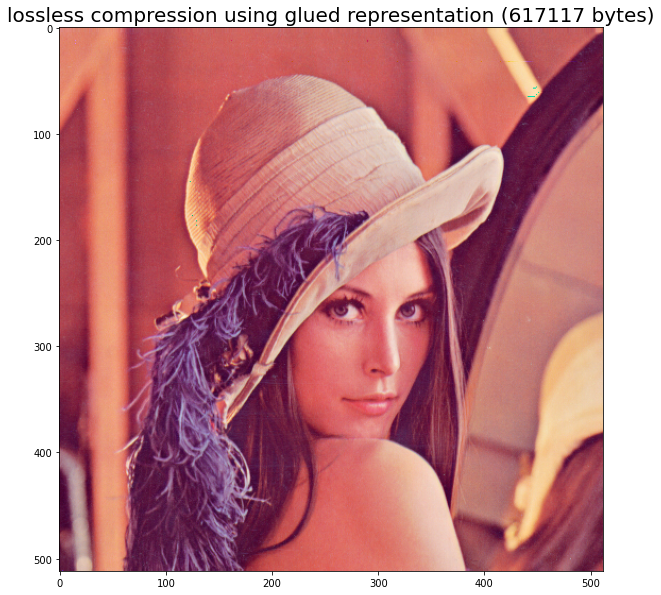

In [7]:
img = RGB_image.read(test_image).astype(np.int16)
RGB_image.show(img, f"original {test_image}")
YUV_img = YUV.from_RGB(img)
avgs = [np.average(YUV_img[...,c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])

decom = DWT.analyze(YUV_img, wavelet, N_levels)
decom_ = DWT.add(decom, 32768)
decom__ = DWT.set_type(decom_, np.uint16)
output_len, slices = DWT.write_glued(decom__, "/tmp/lossless", 0)
_decom = DWT.read_glued(slices, "/tmp/lossless", 0)
_decom2 = DWT.add(_decom, -32768)
_YUV_img = DWT.synthesize(_decom2, wavelet, N_levels)
for c in range(3):
    _YUV_img[..., c] += int(avgs[c])
_img = (YUV.to_RGB(_YUV_img)).astype(np.uint8)
RGB_image.show(_img, f"lossless compression using glued representation ({output_len} bytes)")
print(f"output_length={output_len}")

### Using the "unglued" representation
In this case, depending on the subband, we will use 8 or 16 bits/coefficient in the subband-components. TODO: signal empty subbands with a bit and avoid sending them.

In [8]:
def drange(x):
    return x.max() - x.min()

def add_offset(x):
    if drange(x) < 256:
        x = (x + 128).astype(np.uint8)
    else:
        x = (x + 32768).astype(np.uint16)
    return x

def sub_offset(x):
    if drange(x) < 256:
        x = x.astype(np.float64) - 128
    else:
        x = x.astype(np.float64) - 32768
    return x

[image_3.py:42 read() INFO] /home/vruiz/repos/MRVC/images/lena_color/000.png (512, 512, 3) uint8 len=512673 max=255 min=1
[image_3.py:55 write() INFO] Before optipng: 1390 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/losslessLL5000.png
[image_3.py:62 write() INFO] /tmp/losslessLL5000.png (16, 16, 3) uint16 len=1378 max=38014 min=28277
[image_3.py:55 write() INFO] Before optipng: 1324 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/losslessLH5000.png
[image_3.py:62 write() INFO] /tmp/losslessLH5000.png (16, 16, 3) uint16 len=1250 max=34515 min=31529
[image_3.py:55 write() INFO] Before optipng: 1353 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/losslessHL5000.png
[image_3.py:62 write() INFO] /tmp/losslessHL5000.png (16, 16, 3) uint16 len=1324 max=35123 min=30312
[image_3.py:55 write() INFO] Before optipng: 1315 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/losslessHH5000.png
[image_3.py:62 write() INFO] /tmp/losslessHH5000.png (16, 16, 3) uint16 len=1241 max=34117 min=31542
[i

avgs=[217.13040549266634, 17.98332955505486, 77.04341443311425]


[image_3.py:62 write() INFO] /tmp/losslessHH3000.png (64, 64, 3) uint16 len=12749 max=33267 min=32419
[image_3.py:55 write() INFO] Before optipng: 51444 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/losslessLH2000.png
[image_3.py:62 write() INFO] /tmp/losslessLH2000.png (128, 128, 3) uint16 len=42698 max=33054 min=32497
[image_3.py:55 write() INFO] Before optipng: 53175 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/losslessHL2000.png
[image_3.py:62 write() INFO] /tmp/losslessHL2000.png (128, 128, 3) uint16 len=46029 max=33090 min=32323
[image_3.py:55 write() INFO] Before optipng: 50062 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/losslessHH2000.png
[image_3.py:62 write() INFO] /tmp/losslessHH2000.png (128, 128, 3) uint16 len=40770 max=32965 min=32598
[image_3.py:55 write() INFO] Before optipng: 125589 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/losslessLH1000.png
[image_3.py:62 write() INFO] /tmp/losslessLH1000.png (256, 256, 3) uint8 len=104917 max=249 min=1
[image_3.py

output_length=547469


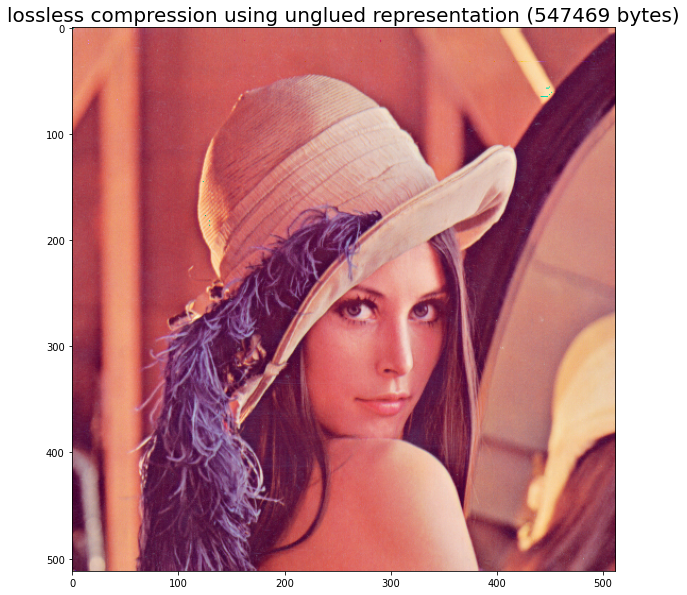

In [9]:
img = RGB_image.read(test_image).astype(np.int16)
YUV_img = YUV.from_RGB(img)
avgs = [np.average(YUV_img[...,c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
decom = DWT.analyze(YUV_img, wavelet, N_levels)
always_positive_decom = [add_offset(decom[0])] # always_positive_decom is PNG friendly
for sr in decom[1:]: # sr = spatial_resolution
    always_positive_sr = []
    for sb in sr: # sb = subband
        always_positive_sr.append(add_offset(sb))
    always_positive_decom.append(tuple(always_positive_sr))
output_len, slices = DWT.write_unglued(always_positive_decom, "/tmp/lossless", 0)
_always_positive_decom = DWT.read_unglued(slices, "/tmp/lossless", 0)
#assert (always_positive_decom[0]==_always_positive_decom[0]).all()
#for sr, _sr in zip(always_positive_decom[1:], _always_positive_decom[1:]):
#    for sb, _sb in zip(sr, _sr):
#        assert (sb==_sb).all()
_decom = [sub_offset(always_positive_decom[0])]
for always_positive_sr in always_positive_decom[1:]:
    sr = []
    for always_positive_sb in always_positive_sr:
        sr.append(sub_offset(always_positive_sb))
    _decom.append(tuple(sr))
_YUV_img = DWT.synthesize(_decom, wavelet, N_levels)
for c in range(3):
    _YUV_img[..., c] += int(avgs[c])
_img = YUV.to_RGB(_YUV_img).astype(np.uint8)
RGB_image.show(_img, f"lossless compression using unglued representation ({output_len} bytes)")
print(f"output_length={output_len}")

## RD performance using uniform quantization among subbands

All subbands are quantized with the same quantization step. Notice that all subbands should have the same gain.

### Measuring the distortion in the transform domain (TO-DO)

Only works if the color/spatial transform is orthogonal.

In [10]:
Q_steps = [256, 128, 64, 32, 16, 8, 4, 2, 1]
img = RGB_image.read(test_image)
YUV_img = YUV.from_RGB(img.astype(np.int16))
avgs = [np.average(YUV_img[..., c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
decom = DWT.analyze(YUV_img, wavelet, N_levels)
LL = decom[0]
for Q_step in Q_steps:
    Q = Quantizer(Q_step=Q_step)
    LL_k = Q.quantize(LL)
    LL_dQ = Q.dequantize(LL_k)
    # ....

[image_3.py:42 read() INFO] /home/vruiz/repos/MRVC/images/lena_color/000.png (512, 512, 3) uint8 len=512673 max=255 min=1


avgs=[217.13040549266634, 17.98332955505486, 77.04341443311425]


### Measuring the distortion in the image domain
This is the only choice for non-orthogonal transforms. We compute the inverse transform for each quantization step of each subband-component, and measure the distortion in the image domain. We use unglued representation.

In [11]:
# Use uniform quantization and write_unglued()
#Q_steps = [32, 16, 8, 4, 2, 1, 1/2, 1/4, 1/8, 1/16, 1/32]
#c = 0
#for s in Q_steps:
#    Q_steps[c] *= 64
#    c += 1
Q_steps = [256, 128, 64, 32, 16, 8]

[image_3.py:42 read() INFO] /home/vruiz/repos/MRVC/images/lena_color/000.png (512, 512, 3) uint8 len=512673 max=255 min=1
[image_3.py:55 write() INFO] Before optipng: 462 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_256_LL5000.png
[image_3.py:62 write() INFO] /tmp/constant_256_LL5000.png (16, 16, 3) uint8 len=462 max=148 min=111
[image_3.py:55 write() INFO] Before optipng: 260 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_256_LH5000.png
[image_3.py:62 write() INFO] /tmp/constant_256_LH5000.png (16, 16, 3) uint8 len=222 max=134 min=124
[image_3.py:55 write() INFO] Before optipng: 338 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_256_HL5000.png
[image_3.py:62 write() INFO] /tmp/constant_256_HL5000.png (16, 16, 3) uint8 len=338 max=137 min=119
[image_3.py:55 write() INFO] Before optipng: 243 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_256_HH5000.png
[image_3.py:62 write() INFO] /tmp/constant_256_HH5000.png (16, 16, 3) uint8 len=212 max=13

avgs=[217.13040549266634, 17.98332955505486, 77.04341443311425]


[image_3.py:56 write() DEBUG] optipng /tmp/constant_256_HH1000.png
[image_3.py:62 write() INFO] /tmp/constant_256_HH1000.png (256, 256, 3) uint8 len=103 max=128 min=128
[image_3.py:88 print_stats() INFO] component=0 max=255 min=53 avg=179.40078735351562
[image_3.py:88 print_stats() INFO] component=1 max=255 min=0 avg=98.30856704711914
[image_3.py:88 print_stats() INFO] component=2 max=216 min=19 avg=105.24919891357422
[image_3.py:55 write() INFO] Before optipng: 546 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_128_LL5000.png
[image_3.py:62 write() INFO] /tmp/constant_128_LL5000.png (16, 16, 3) uint8 len=507 max=168 min=93
[image_3.py:55 write() INFO] Before optipng: 375 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_128_LH5000.png
[image_3.py:62 write() INFO] /tmp/constant_128_LH5000.png (16, 16, 3) uint8 len=375 max=141 min=119
[image_3.py:55 write() INFO] Before optipng: 446 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_128_HL5000.png
[image_3.py:6

Q_step=256 BPP=0.108978271484375 RMSE=15.670495329726743


[image_3.py:62 write() INFO] /tmp/constant_128_LH1000.png (256, 256, 3) uint8 len=110 max=129 min=128
[image_3.py:55 write() INFO] Before optipng: 622 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_128_HL1000.png
[image_3.py:62 write() INFO] /tmp/constant_128_HL1000.png (256, 256, 3) uint8 len=197 max=129 min=127
[image_3.py:55 write() INFO] Before optipng: 564 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_128_HH1000.png
[image_3.py:62 write() INFO] /tmp/constant_128_HH1000.png (256, 256, 3) uint8 len=103 max=128 min=128
[image_3.py:88 print_stats() INFO] component=0 max=255 min=48 avg=179.52784729003906
[image_3.py:88 print_stats() INFO] component=1 max=248 min=0 avg=98.4270133972168
[image_3.py:88 print_stats() INFO] component=2 max=225 min=25 avg=105.12770462036133
[image_3.py:55 write() INFO] Before optipng: 636 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_64_LL5000.png
[image_3.py:62 write() INFO] /tmp/constant_64_LL5000.png (16, 16, 3) uint8 le

Q_step=128 BPP=0.193450927734375 RMSE=11.756767758817286


[image_3.py:62 write() INFO] /tmp/constant_64_HL2000.png (128, 128, 3) uint8 len=1610 max=133 min=122
[image_3.py:55 write() INFO] Before optipng: 1099 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_64_HH2000.png
[image_3.py:62 write() INFO] /tmp/constant_64_HH2000.png (128, 128, 3) uint8 len=633 max=131 min=126
[image_3.py:55 write() INFO] Before optipng: 743 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_64_LH1000.png
[image_3.py:62 write() INFO] /tmp/constant_64_LH1000.png (256, 256, 3) uint8 len=354 max=130 min=127
[image_3.py:55 write() INFO] Before optipng: 1561 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_64_HL1000.png
[image_3.py:62 write() INFO] /tmp/constant_64_HL1000.png (256, 256, 3) uint8 len=928 max=130 min=126
[image_3.py:55 write() INFO] Before optipng: 574 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_64_HH1000.png
[image_3.py:62 write() INFO] /tmp/constant_64_HH1000.png (256, 256, 3) uint8 len=132 max=128 min=127
[image_3

Q_step=64 BPP=0.37969970703125 RMSE=8.732015528759595


[image_3.py:62 write() INFO] /tmp/constant_32_LH2000.png (128, 128, 3) uint8 len=2020 max=136 min=120
[image_3.py:55 write() INFO] Before optipng: 4493 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_32_HL2000.png
[image_3.py:62 write() INFO] /tmp/constant_32_HL2000.png (128, 128, 3) uint8 len=3091 max=138 min=115
[image_3.py:55 write() INFO] Before optipng: 2592 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_32_HH2000.png
[image_3.py:62 write() INFO] /tmp/constant_32_HH2000.png (128, 128, 3) uint8 len=1581 max=134 min=123
[image_3.py:55 write() INFO] Before optipng: 2482 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_32_LH1000.png
[image_3.py:62 write() INFO] /tmp/constant_32_LH1000.png (256, 256, 3) uint8 len=1484 max=132 min=126
[image_3.py:55 write() INFO] Before optipng: 4913 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_32_HL1000.png
[image_3.py:62 write() INFO] /tmp/constant_32_HL1000.png (256, 256, 3) uint8 len=3240 max=132 min=123
[i

Q_step=32 BPP=0.74884033203125 RMSE=6.526093267879678


[image_3.py:55 write() INFO] Before optipng: 6698 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_16_LH2000.png
[image_3.py:62 write() INFO] /tmp/constant_16_LH2000.png (128, 128, 3) uint8 len=4325 max=145 min=112
[image_3.py:55 write() INFO] Before optipng: 8355 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_16_HL2000.png
[image_3.py:62 write() INFO] /tmp/constant_16_HL2000.png (128, 128, 3) uint8 len=6813 max=148 min=101
[image_3.py:55 write() INFO] Before optipng: 5387 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_16_HH2000.png
[image_3.py:62 write() INFO] /tmp/constant_16_HH2000.png (128, 128, 3) uint8 len=3327 max=140 min=118
[image_3.py:55 write() INFO] Before optipng: 8810 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_16_LH1000.png
[image_3.py:62 write() INFO] /tmp/constant_16_LH1000.png (256, 256, 3) uint8 len=5030 max=136 min=123
[image_3.py:55 write() INFO] Before optipng: 12553 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/cons

Q_step=16 BPP=1.443878173828125 RMSE=4.880512739666886


[image_3.py:55 write() INFO] Before optipng: 13252 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_8_LH2000.png
[image_3.py:62 write() INFO] /tmp/constant_8_LH2000.png (128, 128, 3) uint8 len=9528 max=163 min=95
[image_3.py:55 write() INFO] Before optipng: 15477 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_8_HL2000.png
[image_3.py:62 write() INFO] /tmp/constant_8_HL2000.png (128, 128, 3) uint8 len=12418 max=168 min=73
[image_3.py:55 write() INFO] Before optipng: 11252 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_8_HH2000.png
[image_3.py:62 write() INFO] /tmp/constant_8_HH2000.png (128, 128, 3) uint8 len=8071 max=152 min=107
[image_3.py:55 write() INFO] Before optipng: 26654 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_8_LH1000.png
[image_3.py:62 write() INFO] /tmp/constant_8_LH1000.png (256, 256, 3) uint8 len=18070 max=144 min=118
[image_3.py:55 write() INFO] Before optipng: 35225 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant

Q_step=8 BPP=3.442657470703125 RMSE=3.4425250690907627


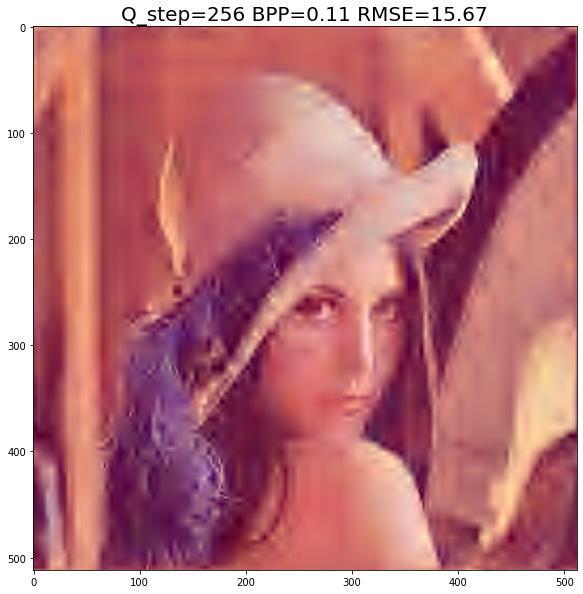

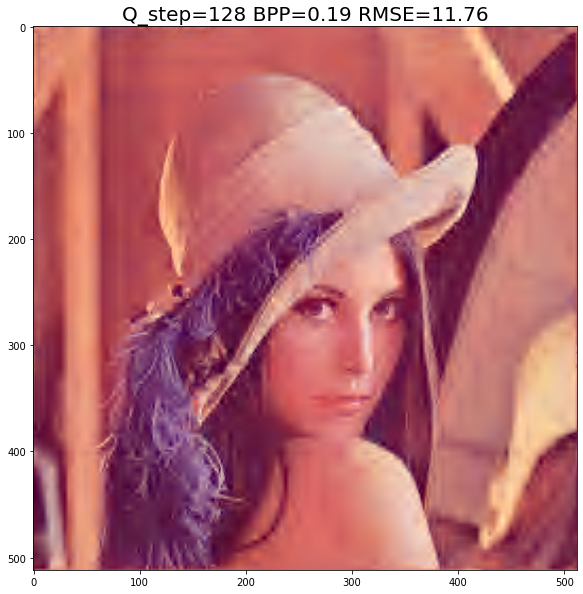

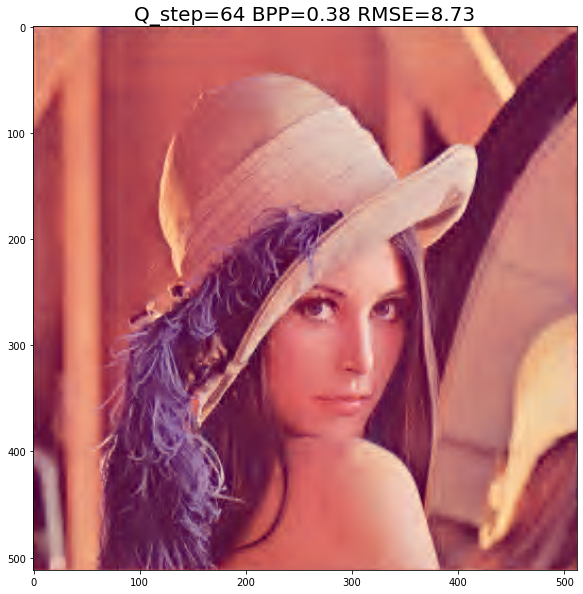

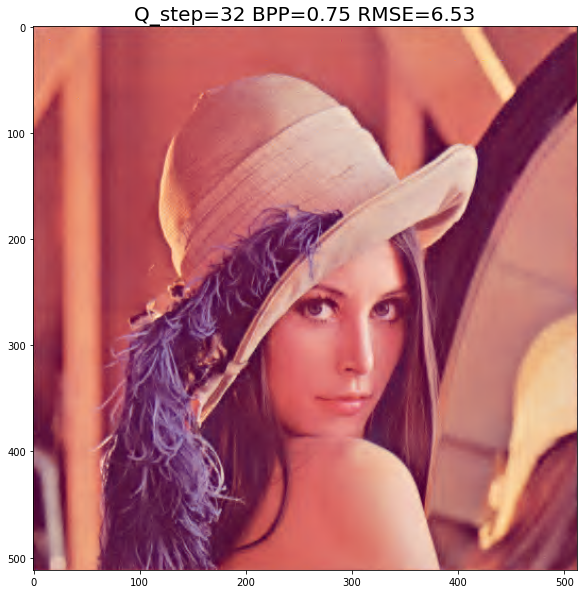

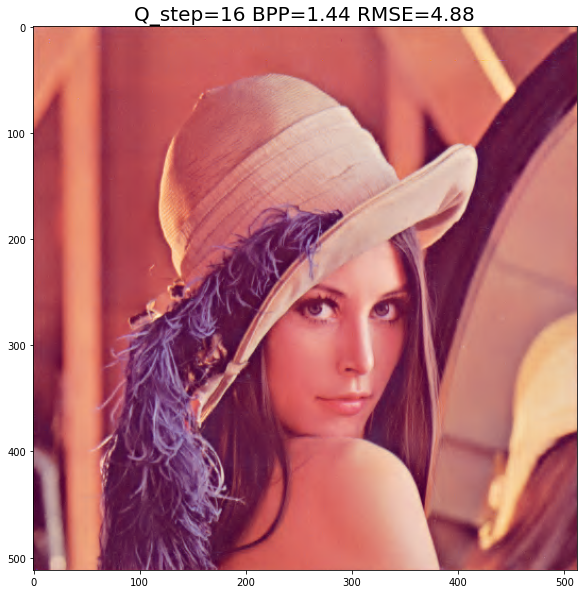

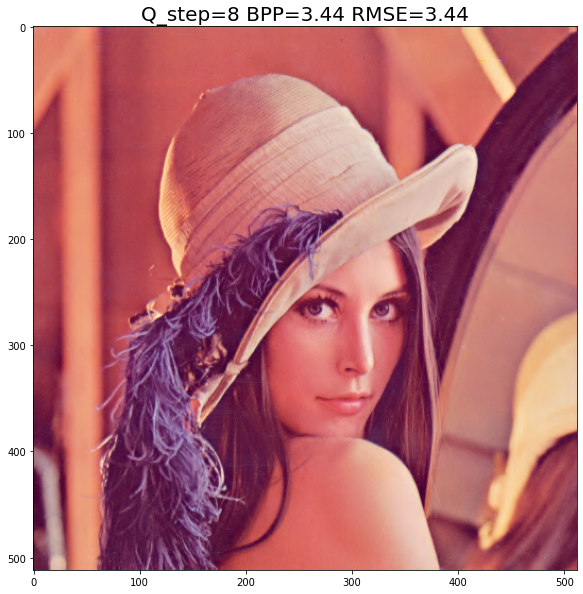

In [12]:
img = RGB_image.read(test_image).astype(np.int16)
YUV_img = YUV.from_RGB(img)
avgs = [np.average(YUV_img[..., c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
decom = DWT.analyze(YUV_img, wavelet, N_levels)
DWT_constantQ = []
for Q_step in Q_steps:
    Q = Quantizer(Q_step=Q_step)
    LL = decom[0]
    LL_k = Q.quantize(LL) # Baybe bettter Q.get_indexes()
    LL_dQ = Q.dequantize(LL_k) # Q.get_signal()
    decom_k = [add_offset(LL_k)]
    decom_dQ = [LL_dQ]
    sbc_counter = 0
    levels_counter = N_levels - 1
    for sr in decom[1:]: # sr = spatial_resolution
        sr_k = []
        sr_dQ = []
        for sb in sr: # sb = subband
            sb_k = Q.quantize(sb)
            sb_dQ = Q.dequantize(sb_k)
            sr_k.append(add_offset(sb_k))
            sr_dQ.append(sb_dQ)
            sbc_counter += 1
        decom_k.append(tuple(sr_k))
        decom_dQ.append(tuple(sr_dQ))
        levels_counter += 1
    BPP = (DWT.write_unglued(decom_k, f"/tmp/constant_{Q_step}_", 0)[0]*8)/(YUV_img.shape[0]*YUV_img.shape[1])
    YUV_img_dQ = DWT.synthesize(decom_dQ, wavelet, N_levels)
    for c in range(3):
        YUV_img_dQ[..., c] += int(avgs[c])
    img_dQ = YUV.to_RGB(YUV_img_dQ)
    img_dQ = np.clip(img_dQ, a_min=0, a_max=255).astype(np.uint8)
    RMSE = distortion.RMSE(img, img_dQ)
    print(f"Q_step={Q_step} BPP={BPP} RMSE={RMSE}")
    DWT_constantQ.append((BPP, RMSE))
    RGB_image.show(img_dQ.astype(np.uint8), f"Q_step={Q_step} BPP={BPP:3.2f} RMSE={RMSE:4.2f}")

pylab.figure(dpi=150)
pylab.plot(*zip(*DCT_RD_points), label=f"DCT uniform Q")
pylab.plot(*zip(*DWT_constantQ), label=f"DWT uniform Q")
#pylab.plot(*zip(*image_domain_DWT_RD_points2), label=f"DWT uniform Q (image domain)")
#pylab.plot(*zip(*transform_domain_DWT_RD_points), label=f"DWT uniform Q (transform domain)")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
#plt.xlim([0, 1])
pylab.show()

The DWT is more efficient than the DCT.

## Uniform quantization using 8-bit/coefficient and glued representation
Notice that the 8-bit representation is not orthonormal (the subbands have an implicit gain of (example for 3 levels)):

    +---+---+-------+---------------+
    | 8 | 4 |       |               |
    +---+---+   2   |               |
    | 4 | 4 |       |               |
    +---+---+-------+       1       |
    |       |       |               |
    |   2   |   2   |               |
    |       |       |               |
    +-------+-------+---------------+
    |               |               |
    |               |               |
    |               |               |
    |       1       |       1       |
    |               |               |
    |               |               |
    |               |               |
    +---------------+---------------+

### Testing the 8/16 bit/coefficient converters

[image_3.py:42 read() INFO] /home/vruiz/repos/MRVC/images/lena_color/000.png (512, 512, 3) uint8 len=512673 max=255 min=1
[image_3.py:88 print_stats() INFO] component=0 max=255 min=0 avg=127.9328498840332
[image_3.py:88 print_stats() INFO] component=1 max=218 min=49 avg=127.95796585083008
[image_3.py:88 print_stats() INFO] component=2 max=171 min=86 avg=127.93256378173828


avgs=[217.13040549266634, 17.98332955505486, 77.04341443311425]
to_8bits: int16
int16


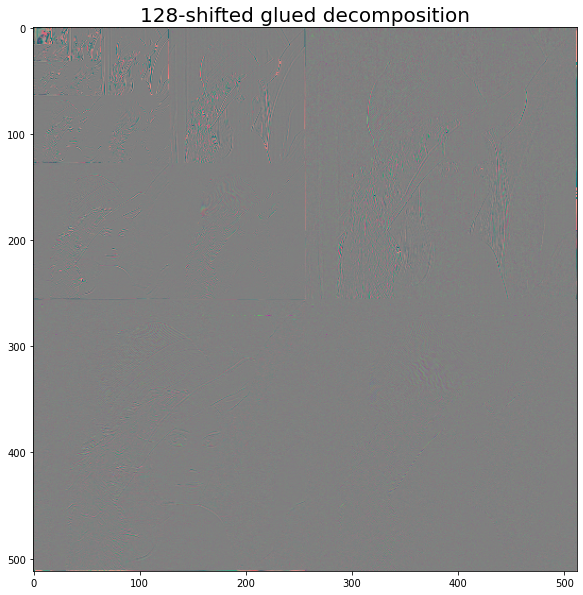

In [13]:
def to_8bits(decomposition): # compact?
    '''Remove the least significant bit-planes of the <decomposition> to represent each coefficient with 8 bits.
    
    Parameters
    ----------
    decomposition: list
        The decomposition to quantize.
        
    Returns:
    decomposition: list
        The quantized decomposition.
    
    '''
    N_levels = len(decomposition) - 1
    #new_decomp = [(decomposition[0].astype(np.int16) >> N_levels).astype(np.uint8)]
    new_decomp = [(decomposition[0].astype(np.int16) >> N_levels)]
    levels_counter = N_levels - 1
    for resolution in decomposition[1:]:
        new_resol = []
        for subband in resolution:
            #new_resol.append((subband.astype(np.int16) >> levels_counter).astype(np.uint8))
            new_resol.append((subband.astype(np.int16) >> levels_counter))
        new_decomp.append(tuple(new_resol))
        levels_counter -= 1
    print("to_8bits:", new_decomp[0].dtype)
    return new_decomp

def to_16bits(decomposition): # uncompact ?
    N_levels = len(decomposition) - 1
    new_decomp = [decomposition[0].astype(np.int16) << N_levels]
    levels_counter = N_levels - 1
    for resolution in decomposition[1:]:
        new_resol = []
        for subband in resolution:
            new_resol.append(subband.astype(np.int16) << levels_counter)
        new_decomp.append(tuple(new_resol))
        levels_counter -= 1
    return new_decomp

img = RGB_image.read(test_image)
YUV_img = YUV.from_RGB(img.astype(np.int16))
avgs = [np.average(YUV_img[...,c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
decom = DWT.analyze(YUV_img, wavelet, N_levels)
#decom_8bit = to_8bits(decom)
decom = to_8bits(decom)
#print(decom_8bit[0].dtype)
print(decom[0].dtype)
#glued_decom_8bit, shapes = DWT.glue_color_decomposition(decom_8bit)
glued_decom, shapes = DWT.glue_color_decomposition(decom)
#image_3.show(image_3.normalize(glued_decom_8bit))
#image_3.show((glued_decom_8bit + 128).astype(np.uint8), "128-shifted glued decomposition")
RGB_image.show((glued_decom + 128).astype(np.uint8), "128-shifted glued decomposition")

[image_3.py:88 print_stats() INFO] component=0 max=255 min=0 avg=178.84355926513672
[image_3.py:88 print_stats() INFO] component=1 max=247 min=1 avg=98.5861701965332
[image_3.py:88 print_stats() INFO] component=2 max=236 min=10 avg=104.93486404418945


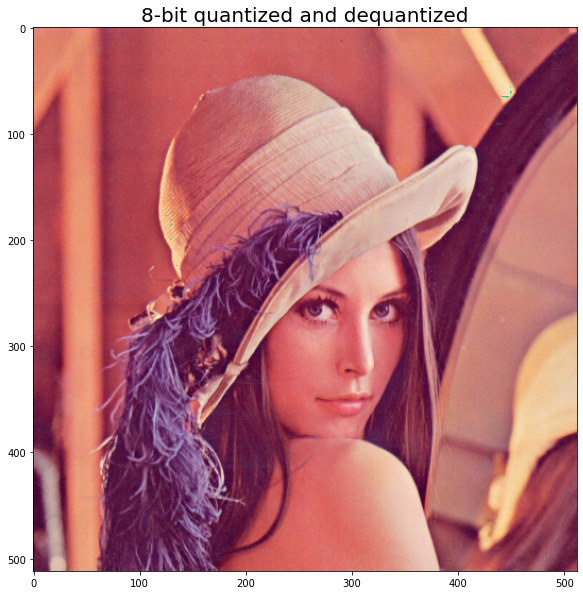

In [14]:
#decom_dQ = to_16bits(decom_8bit)
decom = to_16bits(decom)
#YUV_img_dQ = DWT.synthesize(decom_dQ, wavelet, N_levels)
YUV_img_dQ = DWT.synthesize(decom, wavelet, N_levels)
for c in range(3):
    YUV_img_dQ[..., c] += int(avgs[c])
img_dQ = (YUV.to_RGB(YUV_img_dQ)).astype(np.uint8)
RGB_image.show(img_dQ, "8-bit quantized and dequantized")

int16 255 -4


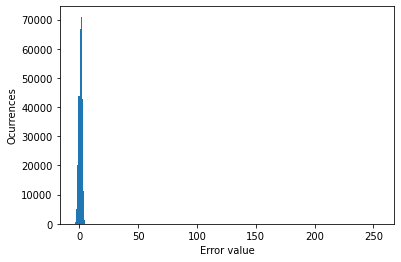

In [15]:
e = img.astype(np.int16) - img_dQ
print(e.dtype, e.max(), e.min())
plt.hist(e[...,0].ravel(), bins=256)
plt.xlabel("Error value")
plt.ylabel("Ocurrences")
plt.show()

[image_3.py:88 print_stats() INFO] component=0 max=1.0 min=0.0 avg=0.02077395759494148
[image_3.py:88 print_stats() INFO] component=1 max=0.03474903474903475 min=0.003861003861003861 avg=0.017259811342452948
[image_3.py:88 print_stats() INFO] component=2 max=0.03088803088803089 min=0.003861003861003861 avg=0.017288679321760373
[image_3.py:88 print_stats() INFO] component=0 max=134 min=124 avg=129.35994720458984
[image_3.py:88 print_stats() INFO] component=1 max=133 min=125 avg=128.4702911376953
[image_3.py:88 print_stats() INFO] component=2 max=132 min=125 avg=128.47776794433594


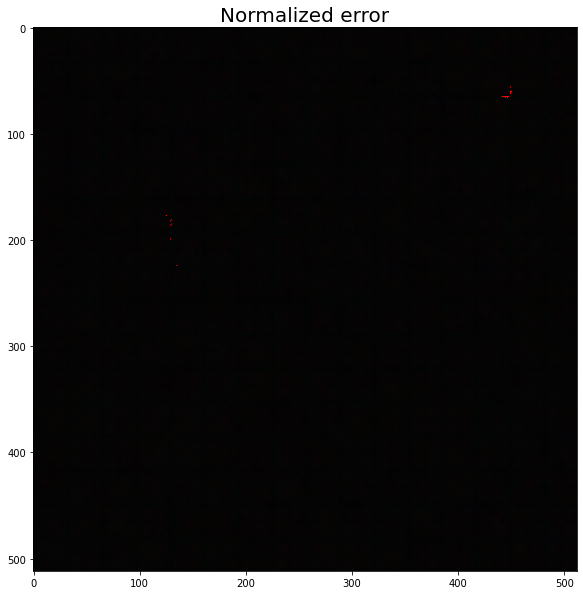

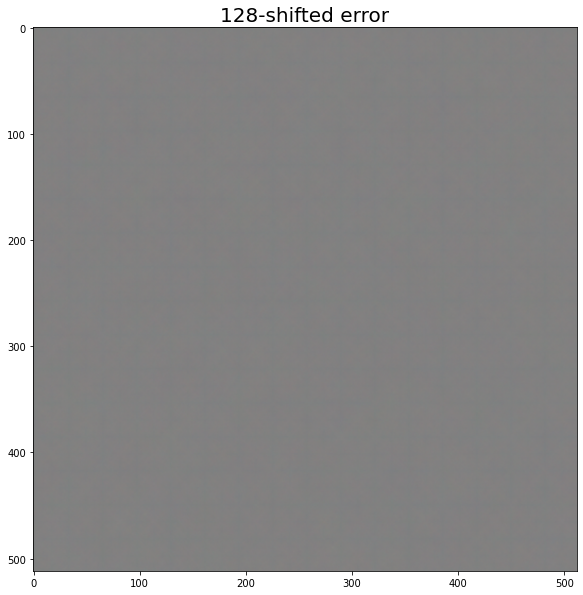

In [16]:
RGB_image.show(RGB_image.normalize(e), "Normalized error")
RGB_image.show((e + 128).astype(np.uint8), "128-shifted error")

In [17]:
subbands_info(to_8bits(decom))

to_8bits: int16
sorting subband-components by entropy
sbc maximum mininum max-min average std-dev entropy        energy  avg-enegy shape
  0   163.0  -141.0   304.0    -0.3    60.3     7.1      931912.0     3640.3 (16, 16)
  6   147.0  -154.0   301.0     2.7    56.3     7.1      814287.0     3180.8 (16, 16)
 15   191.0  -159.0   350.0     0.0    37.4     6.8     1429590.0     1396.1 (32, 32)
 24   203.0  -214.0   417.0     0.1    27.9     6.2     3186342.0      777.9 (64, 64)
  3   109.0   -78.0   187.0    -0.4    22.9     6.0      134309.0      524.6 (16, 16)
  1    32.0   -56.0    88.0     0.5    19.4     5.9       96392.0      376.5 (16, 16)
  9    84.0   -77.0   161.0     0.9    22.2     5.9      126169.0      492.8 (16, 16)
 12   125.0  -156.0   281.0    -0.9    20.1     5.7      413476.0      403.8 (32, 32)
 18   136.0   -92.0   228.0    -0.4    17.0     5.5      297571.0      290.6 (32, 32)
 33   161.0  -222.0   383.0    -0.1    18.9     5.4     5834683.0      356.1 (128, 128)
 

## "Uniform quantization" RD curve using 8-bit glued representation

In [18]:
Q_steps = [256, 128, 64, 32, 16, 8]
Q_steps = range(256, 16, -4)
def compute_Q_step(Q_step, level):
    #step = int(math.ceil(Q_step * math.pow(2, N_levels)))
    step_for_8b = int(math.ceil(Q_step / math.pow(2, level)))
    print(f"compute_Q_step: Q_step={Q_step} level={level + 1} step_for_8b={step_for_8b}")
    return step_for_8b

img = RGB_image.read(test_image)
YUV_img = YUV.from_RGB(img.astype(np.int16))
avgs = [np.average(YUV_img[..., c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
decom = DWT.analyze(YUV_img, wavelet, N_levels)
DWT_8b_constantQ = []
for Q_step in Q_steps:
    decom_8b = to_8bits(decom)
    LL_8b = decom_8b[0]
    _Q_step = compute_Q_step(Q_step, N_levels)
    Q = Quantizer(Q_step=_Q_step)
    LL_8b_k = Q.quantize(LL_8b) # Baybe bettter Q.get_indexes()
    decom_8b_k = [(LL_8b_k + 128).astype(np.uint8)]
    LL_8b_dQ = Q.dequantize(LL_8b_k) # Q.get_signal()
    decom_8b_dQ = [LL_8b_dQ]
    sbc_counter = 0
    level = N_levels - 1
    for sr_8b in decom_8b[1:]: # sr = spatial_resolution
        sr_8b_k = []
        sr_8b_dQ = []
        for sb_8b in sr_8b: # sb = subband
            _Q_step = compute_Q_step(Q_step, level)
            Q = Quantizer(Q_step=_Q_step)
            sb_8b_k = Q.quantize(sb_8b)
            sb_8b_dQ = Q.dequantize(sb_8b_k)
            sr_8b_k.append((sb_8b_k + 128).astype(np.uint8))
            sr_8b_dQ.append(sb_8b_dQ)
            sbc_counter += 1
        decom_8b_k.append(tuple(sr_8b_k))
        decom_8b_dQ.append(tuple(sr_8b_dQ))
        level -= 1
    BPP = (DWT.write_glued(decom_8b_k, f"/tmp/constant_{Q_step}_", 0)[0]*8)/YUV_img.size
    decom_dQ = to_16bits(decom_8b_dQ)
    YUV_img_dQ = DWT.synthesize(decom_dQ, wavelet, N_levels)
    for c in range(3):
        YUV_img_dQ[..., c] += int(avgs[c])
    img_dQ = YUV.to_RGB(YUV_img_dQ)
    img_dQ = np.clip(img_dQ, a_min=0, a_max=255).astype(np.uint8)
    RMSE = distortion.RMSE(img, img_dQ)
    print(f"Q_step={Q_step} BPP={BPP} RMSE={RMSE}")
    DWT_8b_constantQ.append((BPP, RMSE))
    #RGB_image.show(img_dQ.astype(np.uint8), f"Q_step={Q_step} BPP={BPP:3.2f} RMSE={RMSE:4.2f}")

[image_3.py:42 read() INFO] /home/vruiz/repos/MRVC/images/lena_color/000.png (512, 512, 3) uint8 len=512673 max=255 min=1
[image_3.py:55 write() INFO] Before optipng: 4769 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_256_000.png
[image_3.py:62 write() INFO] /tmp/constant_256_000.png (512, 512, 3) uint8 len=3459 max=148 min=111


avgs=[217.13040549266634, 17.98332955505486, 77.04341443311425]
to_8bits: int16
compute_Q_step: Q_step=256 level=6 step_for_8b=8
compute_Q_step: Q_step=256 level=5 step_for_8b=16
compute_Q_step: Q_step=256 level=5 step_for_8b=16
compute_Q_step: Q_step=256 level=5 step_for_8b=16
compute_Q_step: Q_step=256 level=4 step_for_8b=32
compute_Q_step: Q_step=256 level=4 step_for_8b=32
compute_Q_step: Q_step=256 level=4 step_for_8b=32
compute_Q_step: Q_step=256 level=3 step_for_8b=64
compute_Q_step: Q_step=256 level=3 step_for_8b=64
compute_Q_step: Q_step=256 level=3 step_for_8b=64
compute_Q_step: Q_step=256 level=2 step_for_8b=128
compute_Q_step: Q_step=256 level=2 step_for_8b=128
compute_Q_step: Q_step=256 level=2 step_for_8b=128
compute_Q_step: Q_step=256 level=1 step_for_8b=256
compute_Q_step: Q_step=256 level=1 step_for_8b=256
compute_Q_step: Q_step=256 level=1 step_for_8b=256


[image_3.py:55 write() INFO] Before optipng: 4806 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_252_000.png
[image_3.py:62 write() INFO] /tmp/constant_252_000.png (512, 512, 3) uint8 len=3473 max=148 min=111


Q_step=256 BPP=0.035186767578125 RMSE=15.509084479937657
to_8bits: int16
compute_Q_step: Q_step=252 level=6 step_for_8b=8
compute_Q_step: Q_step=252 level=5 step_for_8b=16
compute_Q_step: Q_step=252 level=5 step_for_8b=16
compute_Q_step: Q_step=252 level=5 step_for_8b=16
compute_Q_step: Q_step=252 level=4 step_for_8b=32
compute_Q_step: Q_step=252 level=4 step_for_8b=32
compute_Q_step: Q_step=252 level=4 step_for_8b=32
compute_Q_step: Q_step=252 level=3 step_for_8b=63
compute_Q_step: Q_step=252 level=3 step_for_8b=63
compute_Q_step: Q_step=252 level=3 step_for_8b=63
compute_Q_step: Q_step=252 level=2 step_for_8b=126
compute_Q_step: Q_step=252 level=2 step_for_8b=126
compute_Q_step: Q_step=252 level=2 step_for_8b=126
compute_Q_step: Q_step=252 level=1 step_for_8b=252
compute_Q_step: Q_step=252 level=1 step_for_8b=252
compute_Q_step: Q_step=252 level=1 step_for_8b=252


[image_3.py:55 write() INFO] Before optipng: 4859 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_248_000.png
[image_3.py:62 write() INFO] /tmp/constant_248_000.png (512, 512, 3) uint8 len=3507 max=148 min=111


Q_step=252 BPP=0.035329182942708336 RMSE=15.4921201549611
to_8bits: int16
compute_Q_step: Q_step=248 level=6 step_for_8b=8
compute_Q_step: Q_step=248 level=5 step_for_8b=16
compute_Q_step: Q_step=248 level=5 step_for_8b=16
compute_Q_step: Q_step=248 level=5 step_for_8b=16
compute_Q_step: Q_step=248 level=4 step_for_8b=31
compute_Q_step: Q_step=248 level=4 step_for_8b=31
compute_Q_step: Q_step=248 level=4 step_for_8b=31
compute_Q_step: Q_step=248 level=3 step_for_8b=62
compute_Q_step: Q_step=248 level=3 step_for_8b=62
compute_Q_step: Q_step=248 level=3 step_for_8b=62
compute_Q_step: Q_step=248 level=2 step_for_8b=124
compute_Q_step: Q_step=248 level=2 step_for_8b=124
compute_Q_step: Q_step=248 level=2 step_for_8b=124
compute_Q_step: Q_step=248 level=1 step_for_8b=248
compute_Q_step: Q_step=248 level=1 step_for_8b=248
compute_Q_step: Q_step=248 level=1 step_for_8b=248


[image_3.py:55 write() INFO] Before optipng: 4892 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_244_000.png
[image_3.py:62 write() INFO] /tmp/constant_244_000.png (512, 512, 3) uint8 len=3530 max=148 min=111


Q_step=248 BPP=0.035675048828125 RMSE=15.424073964024714
to_8bits: int16
compute_Q_step: Q_step=244 level=6 step_for_8b=8
compute_Q_step: Q_step=244 level=5 step_for_8b=16
compute_Q_step: Q_step=244 level=5 step_for_8b=16
compute_Q_step: Q_step=244 level=5 step_for_8b=16
compute_Q_step: Q_step=244 level=4 step_for_8b=31
compute_Q_step: Q_step=244 level=4 step_for_8b=31
compute_Q_step: Q_step=244 level=4 step_for_8b=31
compute_Q_step: Q_step=244 level=3 step_for_8b=61
compute_Q_step: Q_step=244 level=3 step_for_8b=61
compute_Q_step: Q_step=244 level=3 step_for_8b=61
compute_Q_step: Q_step=244 level=2 step_for_8b=122
compute_Q_step: Q_step=244 level=2 step_for_8b=122
compute_Q_step: Q_step=244 level=2 step_for_8b=122
compute_Q_step: Q_step=244 level=1 step_for_8b=244
compute_Q_step: Q_step=244 level=1 step_for_8b=244
compute_Q_step: Q_step=244 level=1 step_for_8b=244


[image_3.py:55 write() INFO] Before optipng: 4976 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_240_000.png
[image_3.py:62 write() INFO] /tmp/constant_240_000.png (512, 512, 3) uint8 len=3598 max=148 min=111


Q_step=244 BPP=0.035909016927083336 RMSE=15.394305878242786
to_8bits: int16
compute_Q_step: Q_step=240 level=6 step_for_8b=8
compute_Q_step: Q_step=240 level=5 step_for_8b=15
compute_Q_step: Q_step=240 level=5 step_for_8b=15
compute_Q_step: Q_step=240 level=5 step_for_8b=15
compute_Q_step: Q_step=240 level=4 step_for_8b=30
compute_Q_step: Q_step=240 level=4 step_for_8b=30
compute_Q_step: Q_step=240 level=4 step_for_8b=30
compute_Q_step: Q_step=240 level=3 step_for_8b=60
compute_Q_step: Q_step=240 level=3 step_for_8b=60
compute_Q_step: Q_step=240 level=3 step_for_8b=60
compute_Q_step: Q_step=240 level=2 step_for_8b=120
compute_Q_step: Q_step=240 level=2 step_for_8b=120
compute_Q_step: Q_step=240 level=2 step_for_8b=120
compute_Q_step: Q_step=240 level=1 step_for_8b=240
compute_Q_step: Q_step=240 level=1 step_for_8b=240
compute_Q_step: Q_step=240 level=1 step_for_8b=240


[image_3.py:55 write() INFO] Before optipng: 5052 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_236_000.png
[image_3.py:62 write() INFO] /tmp/constant_236_000.png (512, 512, 3) uint8 len=3629 max=148 min=111


Q_step=240 BPP=0.036600748697916664 RMSE=15.24401900776279
to_8bits: int16
compute_Q_step: Q_step=236 level=6 step_for_8b=8
compute_Q_step: Q_step=236 level=5 step_for_8b=15
compute_Q_step: Q_step=236 level=5 step_for_8b=15
compute_Q_step: Q_step=236 level=5 step_for_8b=15
compute_Q_step: Q_step=236 level=4 step_for_8b=30
compute_Q_step: Q_step=236 level=4 step_for_8b=30
compute_Q_step: Q_step=236 level=4 step_for_8b=30
compute_Q_step: Q_step=236 level=3 step_for_8b=59
compute_Q_step: Q_step=236 level=3 step_for_8b=59
compute_Q_step: Q_step=236 level=3 step_for_8b=59
compute_Q_step: Q_step=236 level=2 step_for_8b=118
compute_Q_step: Q_step=236 level=2 step_for_8b=118
compute_Q_step: Q_step=236 level=2 step_for_8b=118
compute_Q_step: Q_step=236 level=1 step_for_8b=236
compute_Q_step: Q_step=236 level=1 step_for_8b=236
compute_Q_step: Q_step=236 level=1 step_for_8b=236


[image_3.py:55 write() INFO] Before optipng: 5132 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_232_000.png
[image_3.py:62 write() INFO] /tmp/constant_232_000.png (512, 512, 3) uint8 len=3667 max=148 min=111


Q_step=236 BPP=0.036916097005208336 RMSE=15.189413905067557
to_8bits: int16
compute_Q_step: Q_step=232 level=6 step_for_8b=8
compute_Q_step: Q_step=232 level=5 step_for_8b=15
compute_Q_step: Q_step=232 level=5 step_for_8b=15
compute_Q_step: Q_step=232 level=5 step_for_8b=15
compute_Q_step: Q_step=232 level=4 step_for_8b=29
compute_Q_step: Q_step=232 level=4 step_for_8b=29
compute_Q_step: Q_step=232 level=4 step_for_8b=29
compute_Q_step: Q_step=232 level=3 step_for_8b=58
compute_Q_step: Q_step=232 level=3 step_for_8b=58
compute_Q_step: Q_step=232 level=3 step_for_8b=58
compute_Q_step: Q_step=232 level=2 step_for_8b=116
compute_Q_step: Q_step=232 level=2 step_for_8b=116
compute_Q_step: Q_step=232 level=2 step_for_8b=116
compute_Q_step: Q_step=232 level=1 step_for_8b=232
compute_Q_step: Q_step=232 level=1 step_for_8b=232
compute_Q_step: Q_step=232 level=1 step_for_8b=232


[image_3.py:55 write() INFO] Before optipng: 5180 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_228_000.png
[image_3.py:62 write() INFO] /tmp/constant_228_000.png (512, 512, 3) uint8 len=3691 max=148 min=111


Q_step=232 BPP=0.037302652994791664 RMSE=15.099385243547928
to_8bits: int16
compute_Q_step: Q_step=228 level=6 step_for_8b=8
compute_Q_step: Q_step=228 level=5 step_for_8b=15
compute_Q_step: Q_step=228 level=5 step_for_8b=15
compute_Q_step: Q_step=228 level=5 step_for_8b=15
compute_Q_step: Q_step=228 level=4 step_for_8b=29
compute_Q_step: Q_step=228 level=4 step_for_8b=29
compute_Q_step: Q_step=228 level=4 step_for_8b=29
compute_Q_step: Q_step=228 level=3 step_for_8b=57
compute_Q_step: Q_step=228 level=3 step_for_8b=57
compute_Q_step: Q_step=228 level=3 step_for_8b=57
compute_Q_step: Q_step=228 level=2 step_for_8b=114
compute_Q_step: Q_step=228 level=2 step_for_8b=114
compute_Q_step: Q_step=228 level=2 step_for_8b=114
compute_Q_step: Q_step=228 level=1 step_for_8b=228
compute_Q_step: Q_step=228 level=1 step_for_8b=228
compute_Q_step: Q_step=228 level=1 step_for_8b=228


[image_3.py:55 write() INFO] Before optipng: 5341 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_224_000.png
[image_3.py:62 write() INFO] /tmp/constant_224_000.png (512, 512, 3) uint8 len=3875 max=151 min=108


Q_step=228 BPP=0.037546793619791664 RMSE=15.037405507675263
to_8bits: int16
compute_Q_step: Q_step=224 level=6 step_for_8b=7
compute_Q_step: Q_step=224 level=5 step_for_8b=14
compute_Q_step: Q_step=224 level=5 step_for_8b=14
compute_Q_step: Q_step=224 level=5 step_for_8b=14
compute_Q_step: Q_step=224 level=4 step_for_8b=28
compute_Q_step: Q_step=224 level=4 step_for_8b=28
compute_Q_step: Q_step=224 level=4 step_for_8b=28
compute_Q_step: Q_step=224 level=3 step_for_8b=56
compute_Q_step: Q_step=224 level=3 step_for_8b=56
compute_Q_step: Q_step=224 level=3 step_for_8b=56
compute_Q_step: Q_step=224 level=2 step_for_8b=112
compute_Q_step: Q_step=224 level=2 step_for_8b=112
compute_Q_step: Q_step=224 level=2 step_for_8b=112
compute_Q_step: Q_step=224 level=1 step_for_8b=224
compute_Q_step: Q_step=224 level=1 step_for_8b=224
compute_Q_step: Q_step=224 level=1 step_for_8b=224


[image_3.py:55 write() INFO] Before optipng: 5389 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_220_000.png
[image_3.py:62 write() INFO] /tmp/constant_220_000.png (512, 512, 3) uint8 len=3896 max=151 min=108


Q_step=224 BPP=0.039418538411458336 RMSE=14.728117492229238
to_8bits: int16
compute_Q_step: Q_step=220 level=6 step_for_8b=7
compute_Q_step: Q_step=220 level=5 step_for_8b=14
compute_Q_step: Q_step=220 level=5 step_for_8b=14
compute_Q_step: Q_step=220 level=5 step_for_8b=14
compute_Q_step: Q_step=220 level=4 step_for_8b=28
compute_Q_step: Q_step=220 level=4 step_for_8b=28
compute_Q_step: Q_step=220 level=4 step_for_8b=28
compute_Q_step: Q_step=220 level=3 step_for_8b=55
compute_Q_step: Q_step=220 level=3 step_for_8b=55
compute_Q_step: Q_step=220 level=3 step_for_8b=55
compute_Q_step: Q_step=220 level=2 step_for_8b=110
compute_Q_step: Q_step=220 level=2 step_for_8b=110
compute_Q_step: Q_step=220 level=2 step_for_8b=110
compute_Q_step: Q_step=220 level=1 step_for_8b=220
compute_Q_step: Q_step=220 level=1 step_for_8b=220
compute_Q_step: Q_step=220 level=1 step_for_8b=220


[image_3.py:55 write() INFO] Before optipng: 5471 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_216_000.png
[image_3.py:62 write() INFO] /tmp/constant_216_000.png (512, 512, 3) uint8 len=3952 max=151 min=108


Q_step=220 BPP=0.039632161458333336 RMSE=14.68481390449285
to_8bits: int16
compute_Q_step: Q_step=216 level=6 step_for_8b=7
compute_Q_step: Q_step=216 level=5 step_for_8b=14
compute_Q_step: Q_step=216 level=5 step_for_8b=14
compute_Q_step: Q_step=216 level=5 step_for_8b=14
compute_Q_step: Q_step=216 level=4 step_for_8b=27
compute_Q_step: Q_step=216 level=4 step_for_8b=27
compute_Q_step: Q_step=216 level=4 step_for_8b=27
compute_Q_step: Q_step=216 level=3 step_for_8b=54
compute_Q_step: Q_step=216 level=3 step_for_8b=54
compute_Q_step: Q_step=216 level=3 step_for_8b=54
compute_Q_step: Q_step=216 level=2 step_for_8b=108
compute_Q_step: Q_step=216 level=2 step_for_8b=108
compute_Q_step: Q_step=216 level=2 step_for_8b=108
compute_Q_step: Q_step=216 level=1 step_for_8b=216
compute_Q_step: Q_step=216 level=1 step_for_8b=216
compute_Q_step: Q_step=216 level=1 step_for_8b=216


[image_3.py:55 write() INFO] Before optipng: 5538 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_212_000.png
[image_3.py:62 write() INFO] /tmp/constant_212_000.png (512, 512, 3) uint8 len=4011 max=151 min=108


Q_step=216 BPP=0.040201822916666664 RMSE=14.594950787891563
to_8bits: int16
compute_Q_step: Q_step=212 level=6 step_for_8b=7
compute_Q_step: Q_step=212 level=5 step_for_8b=14
compute_Q_step: Q_step=212 level=5 step_for_8b=14
compute_Q_step: Q_step=212 level=5 step_for_8b=14
compute_Q_step: Q_step=212 level=4 step_for_8b=27
compute_Q_step: Q_step=212 level=4 step_for_8b=27
compute_Q_step: Q_step=212 level=4 step_for_8b=27
compute_Q_step: Q_step=212 level=3 step_for_8b=53
compute_Q_step: Q_step=212 level=3 step_for_8b=53
compute_Q_step: Q_step=212 level=3 step_for_8b=53
compute_Q_step: Q_step=212 level=2 step_for_8b=106
compute_Q_step: Q_step=212 level=2 step_for_8b=106
compute_Q_step: Q_step=212 level=2 step_for_8b=106
compute_Q_step: Q_step=212 level=1 step_for_8b=212
compute_Q_step: Q_step=212 level=1 step_for_8b=212
compute_Q_step: Q_step=212 level=1 step_for_8b=212


[image_3.py:55 write() INFO] Before optipng: 5725 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_208_000.png
[image_3.py:62 write() INFO] /tmp/constant_208_000.png (512, 512, 3) uint8 len=4132 max=151 min=108


Q_step=212 BPP=0.040802001953125 RMSE=14.539136752144488
to_8bits: int16
compute_Q_step: Q_step=208 level=6 step_for_8b=7
compute_Q_step: Q_step=208 level=5 step_for_8b=13
compute_Q_step: Q_step=208 level=5 step_for_8b=13
compute_Q_step: Q_step=208 level=5 step_for_8b=13
compute_Q_step: Q_step=208 level=4 step_for_8b=26
compute_Q_step: Q_step=208 level=4 step_for_8b=26
compute_Q_step: Q_step=208 level=4 step_for_8b=26
compute_Q_step: Q_step=208 level=3 step_for_8b=52
compute_Q_step: Q_step=208 level=3 step_for_8b=52
compute_Q_step: Q_step=208 level=3 step_for_8b=52
compute_Q_step: Q_step=208 level=2 step_for_8b=104
compute_Q_step: Q_step=208 level=2 step_for_8b=104
compute_Q_step: Q_step=208 level=2 step_for_8b=104
compute_Q_step: Q_step=208 level=1 step_for_8b=208
compute_Q_step: Q_step=208 level=1 step_for_8b=208
compute_Q_step: Q_step=208 level=1 step_for_8b=208


[image_3.py:55 write() INFO] Before optipng: 5819 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_204_000.png
[image_3.py:62 write() INFO] /tmp/constant_204_000.png (512, 512, 3) uint8 len=4195 max=151 min=108


Q_step=208 BPP=0.042032877604166664 RMSE=14.339591826052546
to_8bits: int16
compute_Q_step: Q_step=204 level=6 step_for_8b=7
compute_Q_step: Q_step=204 level=5 step_for_8b=13
compute_Q_step: Q_step=204 level=5 step_for_8b=13
compute_Q_step: Q_step=204 level=5 step_for_8b=13
compute_Q_step: Q_step=204 level=4 step_for_8b=26
compute_Q_step: Q_step=204 level=4 step_for_8b=26
compute_Q_step: Q_step=204 level=4 step_for_8b=26
compute_Q_step: Q_step=204 level=3 step_for_8b=51
compute_Q_step: Q_step=204 level=3 step_for_8b=51
compute_Q_step: Q_step=204 level=3 step_for_8b=51
compute_Q_step: Q_step=204 level=2 step_for_8b=102
compute_Q_step: Q_step=204 level=2 step_for_8b=102
compute_Q_step: Q_step=204 level=2 step_for_8b=102
compute_Q_step: Q_step=204 level=1 step_for_8b=204
compute_Q_step: Q_step=204 level=1 step_for_8b=204
compute_Q_step: Q_step=204 level=1 step_for_8b=204


[image_3.py:55 write() INFO] Before optipng: 5925 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_200_000.png
[image_3.py:62 write() INFO] /tmp/constant_200_000.png (512, 512, 3) uint8 len=4261 max=151 min=108


Q_step=204 BPP=0.042673746744791664 RMSE=14.279093128048746
to_8bits: int16
compute_Q_step: Q_step=200 level=6 step_for_8b=7
compute_Q_step: Q_step=200 level=5 step_for_8b=13
compute_Q_step: Q_step=200 level=5 step_for_8b=13
compute_Q_step: Q_step=200 level=5 step_for_8b=13
compute_Q_step: Q_step=200 level=4 step_for_8b=25
compute_Q_step: Q_step=200 level=4 step_for_8b=25
compute_Q_step: Q_step=200 level=4 step_for_8b=25
compute_Q_step: Q_step=200 level=3 step_for_8b=50
compute_Q_step: Q_step=200 level=3 step_for_8b=50
compute_Q_step: Q_step=200 level=3 step_for_8b=50
compute_Q_step: Q_step=200 level=2 step_for_8b=100
compute_Q_step: Q_step=200 level=2 step_for_8b=100
compute_Q_step: Q_step=200 level=2 step_for_8b=100
compute_Q_step: Q_step=200 level=1 step_for_8b=200
compute_Q_step: Q_step=200 level=1 step_for_8b=200
compute_Q_step: Q_step=200 level=1 step_for_8b=200


[image_3.py:55 write() INFO] Before optipng: 5987 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_196_000.png
[image_3.py:62 write() INFO] /tmp/constant_196_000.png (512, 512, 3) uint8 len=4308 max=151 min=108


Q_step=200 BPP=0.043345133463541664 RMSE=14.157786709069738
to_8bits: int16
compute_Q_step: Q_step=196 level=6 step_for_8b=7
compute_Q_step: Q_step=196 level=5 step_for_8b=13
compute_Q_step: Q_step=196 level=5 step_for_8b=13
compute_Q_step: Q_step=196 level=5 step_for_8b=13
compute_Q_step: Q_step=196 level=4 step_for_8b=25
compute_Q_step: Q_step=196 level=4 step_for_8b=25
compute_Q_step: Q_step=196 level=4 step_for_8b=25
compute_Q_step: Q_step=196 level=3 step_for_8b=49
compute_Q_step: Q_step=196 level=3 step_for_8b=49
compute_Q_step: Q_step=196 level=3 step_for_8b=49
compute_Q_step: Q_step=196 level=2 step_for_8b=98
compute_Q_step: Q_step=196 level=2 step_for_8b=98
compute_Q_step: Q_step=196 level=2 step_for_8b=98
compute_Q_step: Q_step=196 level=1 step_for_8b=196
compute_Q_step: Q_step=196 level=1 step_for_8b=196
compute_Q_step: Q_step=196 level=1 step_for_8b=196


[image_3.py:55 write() INFO] Before optipng: 6197 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_192_000.png
[image_3.py:62 write() INFO] /tmp/constant_192_000.png (512, 512, 3) uint8 len=4503 max=155 min=105


Q_step=196 BPP=0.0438232421875 RMSE=14.082372839563668
to_8bits: int16
compute_Q_step: Q_step=192 level=6 step_for_8b=6
compute_Q_step: Q_step=192 level=5 step_for_8b=12
compute_Q_step: Q_step=192 level=5 step_for_8b=12
compute_Q_step: Q_step=192 level=5 step_for_8b=12
compute_Q_step: Q_step=192 level=4 step_for_8b=24
compute_Q_step: Q_step=192 level=4 step_for_8b=24
compute_Q_step: Q_step=192 level=4 step_for_8b=24
compute_Q_step: Q_step=192 level=3 step_for_8b=48
compute_Q_step: Q_step=192 level=3 step_for_8b=48
compute_Q_step: Q_step=192 level=3 step_for_8b=48
compute_Q_step: Q_step=192 level=2 step_for_8b=96
compute_Q_step: Q_step=192 level=2 step_for_8b=96
compute_Q_step: Q_step=192 level=2 step_for_8b=96
compute_Q_step: Q_step=192 level=1 step_for_8b=192
compute_Q_step: Q_step=192 level=1 step_for_8b=192
compute_Q_step: Q_step=192 level=1 step_for_8b=192


[image_3.py:55 write() INFO] Before optipng: 6257 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_188_000.png
[image_3.py:62 write() INFO] /tmp/constant_188_000.png (512, 512, 3) uint8 len=4538 max=155 min=105


Q_step=192 BPP=0.045806884765625 RMSE=13.762551745814935
to_8bits: int16
compute_Q_step: Q_step=188 level=6 step_for_8b=6
compute_Q_step: Q_step=188 level=5 step_for_8b=12
compute_Q_step: Q_step=188 level=5 step_for_8b=12
compute_Q_step: Q_step=188 level=5 step_for_8b=12
compute_Q_step: Q_step=188 level=4 step_for_8b=24
compute_Q_step: Q_step=188 level=4 step_for_8b=24
compute_Q_step: Q_step=188 level=4 step_for_8b=24
compute_Q_step: Q_step=188 level=3 step_for_8b=47
compute_Q_step: Q_step=188 level=3 step_for_8b=47
compute_Q_step: Q_step=188 level=3 step_for_8b=47
compute_Q_step: Q_step=188 level=2 step_for_8b=94
compute_Q_step: Q_step=188 level=2 step_for_8b=94
compute_Q_step: Q_step=188 level=2 step_for_8b=94
compute_Q_step: Q_step=188 level=1 step_for_8b=188
compute_Q_step: Q_step=188 level=1 step_for_8b=188
compute_Q_step: Q_step=188 level=1 step_for_8b=188


[image_3.py:55 write() INFO] Before optipng: 6365 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_184_000.png
[image_3.py:62 write() INFO] /tmp/constant_184_000.png (512, 512, 3) uint8 len=4605 max=155 min=105


Q_step=188 BPP=0.046162923177083336 RMSE=13.711563348207392
to_8bits: int16
compute_Q_step: Q_step=184 level=6 step_for_8b=6
compute_Q_step: Q_step=184 level=5 step_for_8b=12
compute_Q_step: Q_step=184 level=5 step_for_8b=12
compute_Q_step: Q_step=184 level=5 step_for_8b=12
compute_Q_step: Q_step=184 level=4 step_for_8b=23
compute_Q_step: Q_step=184 level=4 step_for_8b=23
compute_Q_step: Q_step=184 level=4 step_for_8b=23
compute_Q_step: Q_step=184 level=3 step_for_8b=46
compute_Q_step: Q_step=184 level=3 step_for_8b=46
compute_Q_step: Q_step=184 level=3 step_for_8b=46
compute_Q_step: Q_step=184 level=2 step_for_8b=92
compute_Q_step: Q_step=184 level=2 step_for_8b=92
compute_Q_step: Q_step=184 level=2 step_for_8b=92
compute_Q_step: Q_step=184 level=1 step_for_8b=184
compute_Q_step: Q_step=184 level=1 step_for_8b=184
compute_Q_step: Q_step=184 level=1 step_for_8b=184


[image_3.py:55 write() INFO] Before optipng: 6429 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_180_000.png
[image_3.py:62 write() INFO] /tmp/constant_180_000.png (512, 512, 3) uint8 len=4660 max=155 min=105


Q_step=184 BPP=0.046844482421875 RMSE=13.604666513292669
to_8bits: int16
compute_Q_step: Q_step=180 level=6 step_for_8b=6
compute_Q_step: Q_step=180 level=5 step_for_8b=12
compute_Q_step: Q_step=180 level=5 step_for_8b=12
compute_Q_step: Q_step=180 level=5 step_for_8b=12
compute_Q_step: Q_step=180 level=4 step_for_8b=23
compute_Q_step: Q_step=180 level=4 step_for_8b=23
compute_Q_step: Q_step=180 level=4 step_for_8b=23
compute_Q_step: Q_step=180 level=3 step_for_8b=45
compute_Q_step: Q_step=180 level=3 step_for_8b=45
compute_Q_step: Q_step=180 level=3 step_for_8b=45
compute_Q_step: Q_step=180 level=2 step_for_8b=90
compute_Q_step: Q_step=180 level=2 step_for_8b=90
compute_Q_step: Q_step=180 level=2 step_for_8b=90
compute_Q_step: Q_step=180 level=1 step_for_8b=180
compute_Q_step: Q_step=180 level=1 step_for_8b=180
compute_Q_step: Q_step=180 level=1 step_for_8b=180


[image_3.py:55 write() INFO] Before optipng: 6677 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_176_000.png
[image_3.py:62 write() INFO] /tmp/constant_176_000.png (512, 512, 3) uint8 len=4833 max=155 min=105


Q_step=180 BPP=0.047403971354166664 RMSE=13.548036706635004
to_8bits: int16
compute_Q_step: Q_step=176 level=6 step_for_8b=6
compute_Q_step: Q_step=176 level=5 step_for_8b=11
compute_Q_step: Q_step=176 level=5 step_for_8b=11
compute_Q_step: Q_step=176 level=5 step_for_8b=11
compute_Q_step: Q_step=176 level=4 step_for_8b=22
compute_Q_step: Q_step=176 level=4 step_for_8b=22
compute_Q_step: Q_step=176 level=4 step_for_8b=22
compute_Q_step: Q_step=176 level=3 step_for_8b=44
compute_Q_step: Q_step=176 level=3 step_for_8b=44
compute_Q_step: Q_step=176 level=3 step_for_8b=44
compute_Q_step: Q_step=176 level=2 step_for_8b=88
compute_Q_step: Q_step=176 level=2 step_for_8b=88
compute_Q_step: Q_step=176 level=2 step_for_8b=88
compute_Q_step: Q_step=176 level=1 step_for_8b=176
compute_Q_step: Q_step=176 level=1 step_for_8b=176
compute_Q_step: Q_step=176 level=1 step_for_8b=176


[image_3.py:55 write() INFO] Before optipng: 6753 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_172_000.png
[image_3.py:62 write() INFO] /tmp/constant_172_000.png (512, 512, 3) uint8 len=4887 max=155 min=105


Q_step=176 BPP=0.049163818359375 RMSE=13.33000496011667
to_8bits: int16
compute_Q_step: Q_step=172 level=6 step_for_8b=6
compute_Q_step: Q_step=172 level=5 step_for_8b=11
compute_Q_step: Q_step=172 level=5 step_for_8b=11
compute_Q_step: Q_step=172 level=5 step_for_8b=11
compute_Q_step: Q_step=172 level=4 step_for_8b=22
compute_Q_step: Q_step=172 level=4 step_for_8b=22
compute_Q_step: Q_step=172 level=4 step_for_8b=22
compute_Q_step: Q_step=172 level=3 step_for_8b=43
compute_Q_step: Q_step=172 level=3 step_for_8b=43
compute_Q_step: Q_step=172 level=3 step_for_8b=43
compute_Q_step: Q_step=172 level=2 step_for_8b=86
compute_Q_step: Q_step=172 level=2 step_for_8b=86
compute_Q_step: Q_step=172 level=2 step_for_8b=86
compute_Q_step: Q_step=172 level=1 step_for_8b=172
compute_Q_step: Q_step=172 level=1 step_for_8b=172
compute_Q_step: Q_step=172 level=1 step_for_8b=172


[image_3.py:55 write() INFO] Before optipng: 6953 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_168_000.png
[image_3.py:62 write() INFO] /tmp/constant_168_000.png (512, 512, 3) uint8 len=4963 max=155 min=105


Q_step=172 BPP=0.049713134765625 RMSE=13.278199902523202
to_8bits: int16
compute_Q_step: Q_step=168 level=6 step_for_8b=6
compute_Q_step: Q_step=168 level=5 step_for_8b=11
compute_Q_step: Q_step=168 level=5 step_for_8b=11
compute_Q_step: Q_step=168 level=5 step_for_8b=11
compute_Q_step: Q_step=168 level=4 step_for_8b=21
compute_Q_step: Q_step=168 level=4 step_for_8b=21
compute_Q_step: Q_step=168 level=4 step_for_8b=21
compute_Q_step: Q_step=168 level=3 step_for_8b=42
compute_Q_step: Q_step=168 level=3 step_for_8b=42
compute_Q_step: Q_step=168 level=3 step_for_8b=42
compute_Q_step: Q_step=168 level=2 step_for_8b=84
compute_Q_step: Q_step=168 level=2 step_for_8b=84
compute_Q_step: Q_step=168 level=2 step_for_8b=84
compute_Q_step: Q_step=168 level=1 step_for_8b=168
compute_Q_step: Q_step=168 level=1 step_for_8b=168
compute_Q_step: Q_step=168 level=1 step_for_8b=168


[image_3.py:55 write() INFO] Before optipng: 7093 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_164_000.png
[image_3.py:62 write() INFO] /tmp/constant_164_000.png (512, 512, 3) uint8 len=5042 max=155 min=105


Q_step=168 BPP=0.050486246744791664 RMSE=13.137222363568725
to_8bits: int16
compute_Q_step: Q_step=164 level=6 step_for_8b=6
compute_Q_step: Q_step=164 level=5 step_for_8b=11
compute_Q_step: Q_step=164 level=5 step_for_8b=11
compute_Q_step: Q_step=164 level=5 step_for_8b=11
compute_Q_step: Q_step=164 level=4 step_for_8b=21
compute_Q_step: Q_step=164 level=4 step_for_8b=21
compute_Q_step: Q_step=164 level=4 step_for_8b=21
compute_Q_step: Q_step=164 level=3 step_for_8b=41
compute_Q_step: Q_step=164 level=3 step_for_8b=41
compute_Q_step: Q_step=164 level=3 step_for_8b=41
compute_Q_step: Q_step=164 level=2 step_for_8b=82
compute_Q_step: Q_step=164 level=2 step_for_8b=82
compute_Q_step: Q_step=164 level=2 step_for_8b=82
compute_Q_step: Q_step=164 level=1 step_for_8b=164
compute_Q_step: Q_step=164 level=1 step_for_8b=164
compute_Q_step: Q_step=164 level=1 step_for_8b=164


[image_3.py:55 write() INFO] Before optipng: 7352 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_160_000.png


Q_step=164 BPP=0.051289876302083336 RMSE=13.062850533729955
to_8bits: int16
compute_Q_step: Q_step=160 level=6 step_for_8b=5
compute_Q_step: Q_step=160 level=5 step_for_8b=10
compute_Q_step: Q_step=160 level=5 step_for_8b=10
compute_Q_step: Q_step=160 level=5 step_for_8b=10
compute_Q_step: Q_step=160 level=4 step_for_8b=20
compute_Q_step: Q_step=160 level=4 step_for_8b=20
compute_Q_step: Q_step=160 level=4 step_for_8b=20
compute_Q_step: Q_step=160 level=3 step_for_8b=40
compute_Q_step: Q_step=160 level=3 step_for_8b=40
compute_Q_step: Q_step=160 level=3 step_for_8b=40
compute_Q_step: Q_step=160 level=2 step_for_8b=80
compute_Q_step: Q_step=160 level=2 step_for_8b=80
compute_Q_step: Q_step=160 level=2 step_for_8b=80
compute_Q_step: Q_step=160 level=1 step_for_8b=160
compute_Q_step: Q_step=160 level=1 step_for_8b=160
compute_Q_step: Q_step=160 level=1 step_for_8b=160


[image_3.py:62 write() INFO] /tmp/constant_160_000.png (512, 512, 3) uint8 len=6048 max=160 min=100
[image_3.py:55 write() INFO] Before optipng: 7463 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_156_000.png


Q_step=160 BPP=0.0615234375 RMSE=12.707770830223138
to_8bits: int16
compute_Q_step: Q_step=156 level=6 step_for_8b=5
compute_Q_step: Q_step=156 level=5 step_for_8b=10
compute_Q_step: Q_step=156 level=5 step_for_8b=10
compute_Q_step: Q_step=156 level=5 step_for_8b=10
compute_Q_step: Q_step=156 level=4 step_for_8b=20
compute_Q_step: Q_step=156 level=4 step_for_8b=20
compute_Q_step: Q_step=156 level=4 step_for_8b=20
compute_Q_step: Q_step=156 level=3 step_for_8b=39
compute_Q_step: Q_step=156 level=3 step_for_8b=39
compute_Q_step: Q_step=156 level=3 step_for_8b=39
compute_Q_step: Q_step=156 level=2 step_for_8b=78
compute_Q_step: Q_step=156 level=2 step_for_8b=78
compute_Q_step: Q_step=156 level=2 step_for_8b=78
compute_Q_step: Q_step=156 level=1 step_for_8b=156
compute_Q_step: Q_step=156 level=1 step_for_8b=156
compute_Q_step: Q_step=156 level=1 step_for_8b=156


[image_3.py:62 write() INFO] /tmp/constant_156_000.png (512, 512, 3) uint8 len=6138 max=160 min=100
[image_3.py:55 write() INFO] Before optipng: 7646 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_152_000.png


Q_step=156 BPP=0.06243896484375 RMSE=12.64730848143368
to_8bits: int16
compute_Q_step: Q_step=152 level=6 step_for_8b=5
compute_Q_step: Q_step=152 level=5 step_for_8b=10
compute_Q_step: Q_step=152 level=5 step_for_8b=10
compute_Q_step: Q_step=152 level=5 step_for_8b=10
compute_Q_step: Q_step=152 level=4 step_for_8b=19
compute_Q_step: Q_step=152 level=4 step_for_8b=19
compute_Q_step: Q_step=152 level=4 step_for_8b=19
compute_Q_step: Q_step=152 level=3 step_for_8b=38
compute_Q_step: Q_step=152 level=3 step_for_8b=38
compute_Q_step: Q_step=152 level=3 step_for_8b=38
compute_Q_step: Q_step=152 level=2 step_for_8b=76
compute_Q_step: Q_step=152 level=2 step_for_8b=76
compute_Q_step: Q_step=152 level=2 step_for_8b=76
compute_Q_step: Q_step=152 level=1 step_for_8b=152
compute_Q_step: Q_step=152 level=1 step_for_8b=152
compute_Q_step: Q_step=152 level=1 step_for_8b=152


[image_3.py:62 write() INFO] /tmp/constant_152_000.png (512, 512, 3) uint8 len=6320 max=160 min=100
[image_3.py:55 write() INFO] Before optipng: 7799 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_148_000.png


Q_step=152 BPP=0.06429036458333333 RMSE=12.503501605090836
to_8bits: int16
compute_Q_step: Q_step=148 level=6 step_for_8b=5
compute_Q_step: Q_step=148 level=5 step_for_8b=10
compute_Q_step: Q_step=148 level=5 step_for_8b=10
compute_Q_step: Q_step=148 level=5 step_for_8b=10
compute_Q_step: Q_step=148 level=4 step_for_8b=19
compute_Q_step: Q_step=148 level=4 step_for_8b=19
compute_Q_step: Q_step=148 level=4 step_for_8b=19
compute_Q_step: Q_step=148 level=3 step_for_8b=37
compute_Q_step: Q_step=148 level=3 step_for_8b=37
compute_Q_step: Q_step=148 level=3 step_for_8b=37
compute_Q_step: Q_step=148 level=2 step_for_8b=74
compute_Q_step: Q_step=148 level=2 step_for_8b=74
compute_Q_step: Q_step=148 level=2 step_for_8b=74
compute_Q_step: Q_step=148 level=1 step_for_8b=148
compute_Q_step: Q_step=148 level=1 step_for_8b=148
compute_Q_step: Q_step=148 level=1 step_for_8b=148


[image_3.py:62 write() INFO] /tmp/constant_148_000.png (512, 512, 3) uint8 len=6426 max=160 min=100
[image_3.py:55 write() INFO] Before optipng: 8058 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_144_000.png


Q_step=148 BPP=0.06536865234375 RMSE=12.44701498216122
to_8bits: int16
compute_Q_step: Q_step=144 level=6 step_for_8b=5
compute_Q_step: Q_step=144 level=5 step_for_8b=9
compute_Q_step: Q_step=144 level=5 step_for_8b=9
compute_Q_step: Q_step=144 level=5 step_for_8b=9
compute_Q_step: Q_step=144 level=4 step_for_8b=18
compute_Q_step: Q_step=144 level=4 step_for_8b=18
compute_Q_step: Q_step=144 level=4 step_for_8b=18
compute_Q_step: Q_step=144 level=3 step_for_8b=36
compute_Q_step: Q_step=144 level=3 step_for_8b=36
compute_Q_step: Q_step=144 level=3 step_for_8b=36
compute_Q_step: Q_step=144 level=2 step_for_8b=72
compute_Q_step: Q_step=144 level=2 step_for_8b=72
compute_Q_step: Q_step=144 level=2 step_for_8b=72
compute_Q_step: Q_step=144 level=1 step_for_8b=144
compute_Q_step: Q_step=144 level=1 step_for_8b=144
compute_Q_step: Q_step=144 level=1 step_for_8b=144


[image_3.py:62 write() INFO] /tmp/constant_144_000.png (512, 512, 3) uint8 len=6613 max=160 min=100
[image_3.py:55 write() INFO] Before optipng: 8222 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_140_000.png


Q_step=144 BPP=0.06727091471354167 RMSE=12.24146310642656
to_8bits: int16
compute_Q_step: Q_step=140 level=6 step_for_8b=5
compute_Q_step: Q_step=140 level=5 step_for_8b=9
compute_Q_step: Q_step=140 level=5 step_for_8b=9
compute_Q_step: Q_step=140 level=5 step_for_8b=9
compute_Q_step: Q_step=140 level=4 step_for_8b=18
compute_Q_step: Q_step=140 level=4 step_for_8b=18
compute_Q_step: Q_step=140 level=4 step_for_8b=18
compute_Q_step: Q_step=140 level=3 step_for_8b=35
compute_Q_step: Q_step=140 level=3 step_for_8b=35
compute_Q_step: Q_step=140 level=3 step_for_8b=35
compute_Q_step: Q_step=140 level=2 step_for_8b=70
compute_Q_step: Q_step=140 level=2 step_for_8b=70
compute_Q_step: Q_step=140 level=2 step_for_8b=70
compute_Q_step: Q_step=140 level=1 step_for_8b=140
compute_Q_step: Q_step=140 level=1 step_for_8b=140
compute_Q_step: Q_step=140 level=1 step_for_8b=140


[image_3.py:62 write() INFO] /tmp/constant_140_000.png (512, 512, 3) uint8 len=6753 max=160 min=100
[image_3.py:55 write() INFO] Before optipng: 8506 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_136_000.png


Q_step=140 BPP=0.068695068359375 RMSE=12.150662508511704
to_8bits: int16
compute_Q_step: Q_step=136 level=6 step_for_8b=5
compute_Q_step: Q_step=136 level=5 step_for_8b=9
compute_Q_step: Q_step=136 level=5 step_for_8b=9
compute_Q_step: Q_step=136 level=5 step_for_8b=9
compute_Q_step: Q_step=136 level=4 step_for_8b=17
compute_Q_step: Q_step=136 level=4 step_for_8b=17
compute_Q_step: Q_step=136 level=4 step_for_8b=17
compute_Q_step: Q_step=136 level=3 step_for_8b=34
compute_Q_step: Q_step=136 level=3 step_for_8b=34
compute_Q_step: Q_step=136 level=3 step_for_8b=34
compute_Q_step: Q_step=136 level=2 step_for_8b=68
compute_Q_step: Q_step=136 level=2 step_for_8b=68
compute_Q_step: Q_step=136 level=2 step_for_8b=68
compute_Q_step: Q_step=136 level=1 step_for_8b=136
compute_Q_step: Q_step=136 level=1 step_for_8b=136
compute_Q_step: Q_step=136 level=1 step_for_8b=136


[image_3.py:62 write() INFO] /tmp/constant_136_000.png (512, 512, 3) uint8 len=6959 max=160 min=100
[image_3.py:55 write() INFO] Before optipng: 8689 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_132_000.png


Q_step=136 BPP=0.07079060872395833 RMSE=11.979619733563114
to_8bits: int16
compute_Q_step: Q_step=132 level=6 step_for_8b=5
compute_Q_step: Q_step=132 level=5 step_for_8b=9
compute_Q_step: Q_step=132 level=5 step_for_8b=9
compute_Q_step: Q_step=132 level=5 step_for_8b=9
compute_Q_step: Q_step=132 level=4 step_for_8b=17
compute_Q_step: Q_step=132 level=4 step_for_8b=17
compute_Q_step: Q_step=132 level=4 step_for_8b=17
compute_Q_step: Q_step=132 level=3 step_for_8b=33
compute_Q_step: Q_step=132 level=3 step_for_8b=33
compute_Q_step: Q_step=132 level=3 step_for_8b=33
compute_Q_step: Q_step=132 level=2 step_for_8b=66
compute_Q_step: Q_step=132 level=2 step_for_8b=66
compute_Q_step: Q_step=132 level=2 step_for_8b=66
compute_Q_step: Q_step=132 level=1 step_for_8b=132
compute_Q_step: Q_step=132 level=1 step_for_8b=132
compute_Q_step: Q_step=132 level=1 step_for_8b=132


[image_3.py:62 write() INFO] /tmp/constant_132_000.png (512, 512, 3) uint8 len=7085 max=160 min=100
[image_3.py:55 write() INFO] Before optipng: 9078 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_128_000.png


Q_step=132 BPP=0.07207234700520833 RMSE=11.900927965329165
to_8bits: int16
compute_Q_step: Q_step=128 level=6 step_for_8b=4
compute_Q_step: Q_step=128 level=5 step_for_8b=8
compute_Q_step: Q_step=128 level=5 step_for_8b=8
compute_Q_step: Q_step=128 level=5 step_for_8b=8
compute_Q_step: Q_step=128 level=4 step_for_8b=16
compute_Q_step: Q_step=128 level=4 step_for_8b=16
compute_Q_step: Q_step=128 level=4 step_for_8b=16
compute_Q_step: Q_step=128 level=3 step_for_8b=32
compute_Q_step: Q_step=128 level=3 step_for_8b=32
compute_Q_step: Q_step=128 level=3 step_for_8b=32
compute_Q_step: Q_step=128 level=2 step_for_8b=64
compute_Q_step: Q_step=128 level=2 step_for_8b=64
compute_Q_step: Q_step=128 level=2 step_for_8b=64
compute_Q_step: Q_step=128 level=1 step_for_8b=128
compute_Q_step: Q_step=128 level=1 step_for_8b=128
compute_Q_step: Q_step=128 level=1 step_for_8b=128


[image_3.py:62 write() INFO] /tmp/constant_128_000.png (512, 512, 3) uint8 len=7434 max=168 min=93
[image_3.py:55 write() INFO] Before optipng: 9337 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_124_000.png


Q_step=128 BPP=0.07562255859375 RMSE=11.596855577065243
to_8bits: int16
compute_Q_step: Q_step=124 level=6 step_for_8b=4
compute_Q_step: Q_step=124 level=5 step_for_8b=8
compute_Q_step: Q_step=124 level=5 step_for_8b=8
compute_Q_step: Q_step=124 level=5 step_for_8b=8
compute_Q_step: Q_step=124 level=4 step_for_8b=16
compute_Q_step: Q_step=124 level=4 step_for_8b=16
compute_Q_step: Q_step=124 level=4 step_for_8b=16
compute_Q_step: Q_step=124 level=3 step_for_8b=31
compute_Q_step: Q_step=124 level=3 step_for_8b=31
compute_Q_step: Q_step=124 level=3 step_for_8b=31
compute_Q_step: Q_step=124 level=2 step_for_8b=62
compute_Q_step: Q_step=124 level=2 step_for_8b=62
compute_Q_step: Q_step=124 level=2 step_for_8b=62
compute_Q_step: Q_step=124 level=1 step_for_8b=124
compute_Q_step: Q_step=124 level=1 step_for_8b=124
compute_Q_step: Q_step=124 level=1 step_for_8b=124


[image_3.py:62 write() INFO] /tmp/constant_124_000.png (512, 512, 3) uint8 len=7588 max=168 min=93
[image_3.py:55 write() INFO] Before optipng: 9583 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_120_000.png


Q_step=124 BPP=0.07718912760416667 RMSE=11.504739696835534
to_8bits: int16
compute_Q_step: Q_step=120 level=6 step_for_8b=4
compute_Q_step: Q_step=120 level=5 step_for_8b=8
compute_Q_step: Q_step=120 level=5 step_for_8b=8
compute_Q_step: Q_step=120 level=5 step_for_8b=8
compute_Q_step: Q_step=120 level=4 step_for_8b=15
compute_Q_step: Q_step=120 level=4 step_for_8b=15
compute_Q_step: Q_step=120 level=4 step_for_8b=15
compute_Q_step: Q_step=120 level=3 step_for_8b=30
compute_Q_step: Q_step=120 level=3 step_for_8b=30
compute_Q_step: Q_step=120 level=3 step_for_8b=30
compute_Q_step: Q_step=120 level=2 step_for_8b=60
compute_Q_step: Q_step=120 level=2 step_for_8b=60
compute_Q_step: Q_step=120 level=2 step_for_8b=60
compute_Q_step: Q_step=120 level=1 step_for_8b=120
compute_Q_step: Q_step=120 level=1 step_for_8b=120
compute_Q_step: Q_step=120 level=1 step_for_8b=120


[image_3.py:62 write() INFO] /tmp/constant_120_000.png (512, 512, 3) uint8 len=7857 max=168 min=93
[image_3.py:55 write() INFO] Before optipng: 9840 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_116_000.png


Q_step=120 BPP=0.079925537109375 RMSE=11.356338451924897
to_8bits: int16
compute_Q_step: Q_step=116 level=6 step_for_8b=4
compute_Q_step: Q_step=116 level=5 step_for_8b=8
compute_Q_step: Q_step=116 level=5 step_for_8b=8
compute_Q_step: Q_step=116 level=5 step_for_8b=8
compute_Q_step: Q_step=116 level=4 step_for_8b=15
compute_Q_step: Q_step=116 level=4 step_for_8b=15
compute_Q_step: Q_step=116 level=4 step_for_8b=15
compute_Q_step: Q_step=116 level=3 step_for_8b=29
compute_Q_step: Q_step=116 level=3 step_for_8b=29
compute_Q_step: Q_step=116 level=3 step_for_8b=29
compute_Q_step: Q_step=116 level=2 step_for_8b=58
compute_Q_step: Q_step=116 level=2 step_for_8b=58
compute_Q_step: Q_step=116 level=2 step_for_8b=58
compute_Q_step: Q_step=116 level=1 step_for_8b=116
compute_Q_step: Q_step=116 level=1 step_for_8b=116
compute_Q_step: Q_step=116 level=1 step_for_8b=116


[image_3.py:62 write() INFO] /tmp/constant_116_000.png (512, 512, 3) uint8 len=8019 max=168 min=93
[image_3.py:55 write() INFO] Before optipng: 10308 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_112_000.png


Q_step=116 BPP=0.081573486328125 RMSE=11.263736617729803
to_8bits: int16
compute_Q_step: Q_step=112 level=6 step_for_8b=4
compute_Q_step: Q_step=112 level=5 step_for_8b=7
compute_Q_step: Q_step=112 level=5 step_for_8b=7
compute_Q_step: Q_step=112 level=5 step_for_8b=7
compute_Q_step: Q_step=112 level=4 step_for_8b=14
compute_Q_step: Q_step=112 level=4 step_for_8b=14
compute_Q_step: Q_step=112 level=4 step_for_8b=14
compute_Q_step: Q_step=112 level=3 step_for_8b=28
compute_Q_step: Q_step=112 level=3 step_for_8b=28
compute_Q_step: Q_step=112 level=3 step_for_8b=28
compute_Q_step: Q_step=112 level=2 step_for_8b=56
compute_Q_step: Q_step=112 level=2 step_for_8b=56
compute_Q_step: Q_step=112 level=2 step_for_8b=56
compute_Q_step: Q_step=112 level=1 step_for_8b=112
compute_Q_step: Q_step=112 level=1 step_for_8b=112
compute_Q_step: Q_step=112 level=1 step_for_8b=112


[image_3.py:62 write() INFO] /tmp/constant_112_000.png (512, 512, 3) uint8 len=8421 max=168 min=93
[image_3.py:55 write() INFO] Before optipng: 10548 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_108_000.png


Q_step=112 BPP=0.085662841796875 RMSE=10.996938279347365
to_8bits: int16
compute_Q_step: Q_step=108 level=6 step_for_8b=4
compute_Q_step: Q_step=108 level=5 step_for_8b=7
compute_Q_step: Q_step=108 level=5 step_for_8b=7
compute_Q_step: Q_step=108 level=5 step_for_8b=7
compute_Q_step: Q_step=108 level=4 step_for_8b=14
compute_Q_step: Q_step=108 level=4 step_for_8b=14
compute_Q_step: Q_step=108 level=4 step_for_8b=14
compute_Q_step: Q_step=108 level=3 step_for_8b=27
compute_Q_step: Q_step=108 level=3 step_for_8b=27
compute_Q_step: Q_step=108 level=3 step_for_8b=27
compute_Q_step: Q_step=108 level=2 step_for_8b=54
compute_Q_step: Q_step=108 level=2 step_for_8b=54
compute_Q_step: Q_step=108 level=2 step_for_8b=54
compute_Q_step: Q_step=108 level=1 step_for_8b=108
compute_Q_step: Q_step=108 level=1 step_for_8b=108
compute_Q_step: Q_step=108 level=1 step_for_8b=108


[image_3.py:62 write() INFO] /tmp/constant_108_000.png (512, 512, 3) uint8 len=8618 max=168 min=93
[image_3.py:55 write() INFO] Before optipng: 10972 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_104_000.png


Q_step=108 BPP=0.08766682942708333 RMSE=10.893724129187044
to_8bits: int16
compute_Q_step: Q_step=104 level=6 step_for_8b=4
compute_Q_step: Q_step=104 level=5 step_for_8b=7
compute_Q_step: Q_step=104 level=5 step_for_8b=7
compute_Q_step: Q_step=104 level=5 step_for_8b=7
compute_Q_step: Q_step=104 level=4 step_for_8b=13
compute_Q_step: Q_step=104 level=4 step_for_8b=13
compute_Q_step: Q_step=104 level=4 step_for_8b=13
compute_Q_step: Q_step=104 level=3 step_for_8b=26
compute_Q_step: Q_step=104 level=3 step_for_8b=26
compute_Q_step: Q_step=104 level=3 step_for_8b=26
compute_Q_step: Q_step=104 level=2 step_for_8b=52
compute_Q_step: Q_step=104 level=2 step_for_8b=52
compute_Q_step: Q_step=104 level=2 step_for_8b=52
compute_Q_step: Q_step=104 level=1 step_for_8b=104
compute_Q_step: Q_step=104 level=1 step_for_8b=104
compute_Q_step: Q_step=104 level=1 step_for_8b=104


[image_3.py:62 write() INFO] /tmp/constant_104_000.png (512, 512, 3) uint8 len=8951 max=168 min=93
[image_3.py:55 write() INFO] Before optipng: 11282 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_100_000.png


Q_step=104 BPP=0.09105428059895833 RMSE=10.693411279839783
to_8bits: int16
compute_Q_step: Q_step=100 level=6 step_for_8b=4
compute_Q_step: Q_step=100 level=5 step_for_8b=7
compute_Q_step: Q_step=100 level=5 step_for_8b=7
compute_Q_step: Q_step=100 level=5 step_for_8b=7
compute_Q_step: Q_step=100 level=4 step_for_8b=13
compute_Q_step: Q_step=100 level=4 step_for_8b=13
compute_Q_step: Q_step=100 level=4 step_for_8b=13
compute_Q_step: Q_step=100 level=3 step_for_8b=25
compute_Q_step: Q_step=100 level=3 step_for_8b=25
compute_Q_step: Q_step=100 level=3 step_for_8b=25
compute_Q_step: Q_step=100 level=2 step_for_8b=50
compute_Q_step: Q_step=100 level=2 step_for_8b=50
compute_Q_step: Q_step=100 level=2 step_for_8b=50
compute_Q_step: Q_step=100 level=1 step_for_8b=100
compute_Q_step: Q_step=100 level=1 step_for_8b=100
compute_Q_step: Q_step=100 level=1 step_for_8b=100


[image_3.py:62 write() INFO] /tmp/constant_100_000.png (512, 512, 3) uint8 len=9152 max=168 min=93
[image_3.py:55 write() INFO] Before optipng: 11957 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_96_000.png


Q_step=100 BPP=0.09309895833333333 RMSE=10.601947744627763
to_8bits: int16
compute_Q_step: Q_step=96 level=6 step_for_8b=3
compute_Q_step: Q_step=96 level=5 step_for_8b=6
compute_Q_step: Q_step=96 level=5 step_for_8b=6
compute_Q_step: Q_step=96 level=5 step_for_8b=6
compute_Q_step: Q_step=96 level=4 step_for_8b=12
compute_Q_step: Q_step=96 level=4 step_for_8b=12
compute_Q_step: Q_step=96 level=4 step_for_8b=12
compute_Q_step: Q_step=96 level=3 step_for_8b=24
compute_Q_step: Q_step=96 level=3 step_for_8b=24
compute_Q_step: Q_step=96 level=3 step_for_8b=24
compute_Q_step: Q_step=96 level=2 step_for_8b=48
compute_Q_step: Q_step=96 level=2 step_for_8b=48
compute_Q_step: Q_step=96 level=2 step_for_8b=48
compute_Q_step: Q_step=96 level=1 step_for_8b=96
compute_Q_step: Q_step=96 level=1 step_for_8b=96
compute_Q_step: Q_step=96 level=1 step_for_8b=96


[image_3.py:62 write() INFO] /tmp/constant_96_000.png (512, 512, 3) uint8 len=9517 max=182 min=81
[image_3.py:55 write() INFO] Before optipng: 12294 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_92_000.png


Q_step=96 BPP=0.09681193033854167 RMSE=10.253734745589538
to_8bits: int16
compute_Q_step: Q_step=92 level=6 step_for_8b=3
compute_Q_step: Q_step=92 level=5 step_for_8b=6
compute_Q_step: Q_step=92 level=5 step_for_8b=6
compute_Q_step: Q_step=92 level=5 step_for_8b=6
compute_Q_step: Q_step=92 level=4 step_for_8b=12
compute_Q_step: Q_step=92 level=4 step_for_8b=12
compute_Q_step: Q_step=92 level=4 step_for_8b=12
compute_Q_step: Q_step=92 level=3 step_for_8b=23
compute_Q_step: Q_step=92 level=3 step_for_8b=23
compute_Q_step: Q_step=92 level=3 step_for_8b=23
compute_Q_step: Q_step=92 level=2 step_for_8b=46
compute_Q_step: Q_step=92 level=2 step_for_8b=46
compute_Q_step: Q_step=92 level=2 step_for_8b=46
compute_Q_step: Q_step=92 level=1 step_for_8b=92
compute_Q_step: Q_step=92 level=1 step_for_8b=92
compute_Q_step: Q_step=92 level=1 step_for_8b=92


[image_3.py:62 write() INFO] /tmp/constant_92_000.png (512, 512, 3) uint8 len=9608 max=182 min=81
[image_3.py:55 write() INFO] Before optipng: 12891 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_88_000.png


Q_step=92 BPP=0.09773763020833333 RMSE=10.141828515530507
to_8bits: int16
compute_Q_step: Q_step=88 level=6 step_for_8b=3
compute_Q_step: Q_step=88 level=5 step_for_8b=6
compute_Q_step: Q_step=88 level=5 step_for_8b=6
compute_Q_step: Q_step=88 level=5 step_for_8b=6
compute_Q_step: Q_step=88 level=4 step_for_8b=11
compute_Q_step: Q_step=88 level=4 step_for_8b=11
compute_Q_step: Q_step=88 level=4 step_for_8b=11
compute_Q_step: Q_step=88 level=3 step_for_8b=22
compute_Q_step: Q_step=88 level=3 step_for_8b=22
compute_Q_step: Q_step=88 level=3 step_for_8b=22
compute_Q_step: Q_step=88 level=2 step_for_8b=44
compute_Q_step: Q_step=88 level=2 step_for_8b=44
compute_Q_step: Q_step=88 level=2 step_for_8b=44
compute_Q_step: Q_step=88 level=1 step_for_8b=88
compute_Q_step: Q_step=88 level=1 step_for_8b=88
compute_Q_step: Q_step=88 level=1 step_for_8b=88


[image_3.py:62 write() INFO] /tmp/constant_88_000.png (512, 512, 3) uint8 len=10054 max=182 min=81
[image_3.py:55 write() INFO] Before optipng: 13312 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_84_000.png


Q_step=88 BPP=0.10227457682291667 RMSE=9.909074671426831
to_8bits: int16
compute_Q_step: Q_step=84 level=6 step_for_8b=3
compute_Q_step: Q_step=84 level=5 step_for_8b=6
compute_Q_step: Q_step=84 level=5 step_for_8b=6
compute_Q_step: Q_step=84 level=5 step_for_8b=6
compute_Q_step: Q_step=84 level=4 step_for_8b=11
compute_Q_step: Q_step=84 level=4 step_for_8b=11
compute_Q_step: Q_step=84 level=4 step_for_8b=11
compute_Q_step: Q_step=84 level=3 step_for_8b=21
compute_Q_step: Q_step=84 level=3 step_for_8b=21
compute_Q_step: Q_step=84 level=3 step_for_8b=21
compute_Q_step: Q_step=84 level=2 step_for_8b=42
compute_Q_step: Q_step=84 level=2 step_for_8b=42
compute_Q_step: Q_step=84 level=2 step_for_8b=42
compute_Q_step: Q_step=84 level=1 step_for_8b=84
compute_Q_step: Q_step=84 level=1 step_for_8b=84
compute_Q_step: Q_step=84 level=1 step_for_8b=84


[image_3.py:62 write() INFO] /tmp/constant_84_000.png (512, 512, 3) uint8 len=10409 max=182 min=81
[image_3.py:55 write() INFO] Before optipng: 14183 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_80_000.png


Q_step=84 BPP=0.10588582356770833 RMSE=9.793331204962277
to_8bits: int16
compute_Q_step: Q_step=80 level=6 step_for_8b=3
compute_Q_step: Q_step=80 level=5 step_for_8b=5
compute_Q_step: Q_step=80 level=5 step_for_8b=5
compute_Q_step: Q_step=80 level=5 step_for_8b=5
compute_Q_step: Q_step=80 level=4 step_for_8b=10
compute_Q_step: Q_step=80 level=4 step_for_8b=10
compute_Q_step: Q_step=80 level=4 step_for_8b=10
compute_Q_step: Q_step=80 level=3 step_for_8b=20
compute_Q_step: Q_step=80 level=3 step_for_8b=20
compute_Q_step: Q_step=80 level=3 step_for_8b=20
compute_Q_step: Q_step=80 level=2 step_for_8b=40
compute_Q_step: Q_step=80 level=2 step_for_8b=40
compute_Q_step: Q_step=80 level=2 step_for_8b=40
compute_Q_step: Q_step=80 level=1 step_for_8b=80
compute_Q_step: Q_step=80 level=1 step_for_8b=80
compute_Q_step: Q_step=80 level=1 step_for_8b=80


[image_3.py:62 write() INFO] /tmp/constant_80_000.png (512, 512, 3) uint8 len=10999 max=182 min=81
[image_3.py:55 write() INFO] Before optipng: 14807 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_76_000.png


Q_step=80 BPP=0.11188761393229167 RMSE=9.491787556410642
to_8bits: int16
compute_Q_step: Q_step=76 level=6 step_for_8b=3
compute_Q_step: Q_step=76 level=5 step_for_8b=5
compute_Q_step: Q_step=76 level=5 step_for_8b=5
compute_Q_step: Q_step=76 level=5 step_for_8b=5
compute_Q_step: Q_step=76 level=4 step_for_8b=10
compute_Q_step: Q_step=76 level=4 step_for_8b=10
compute_Q_step: Q_step=76 level=4 step_for_8b=10
compute_Q_step: Q_step=76 level=3 step_for_8b=19
compute_Q_step: Q_step=76 level=3 step_for_8b=19
compute_Q_step: Q_step=76 level=3 step_for_8b=19
compute_Q_step: Q_step=76 level=2 step_for_8b=38
compute_Q_step: Q_step=76 level=2 step_for_8b=38
compute_Q_step: Q_step=76 level=2 step_for_8b=38
compute_Q_step: Q_step=76 level=1 step_for_8b=76
compute_Q_step: Q_step=76 level=1 step_for_8b=76
compute_Q_step: Q_step=76 level=1 step_for_8b=76


[image_3.py:62 write() INFO] /tmp/constant_76_000.png (512, 512, 3) uint8 len=11443 max=182 min=81
[image_3.py:55 write() INFO] Before optipng: 15633 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_72_000.png


Q_step=76 BPP=0.11640421549479167 RMSE=9.340756484333893
to_8bits: int16
compute_Q_step: Q_step=72 level=6 step_for_8b=3
compute_Q_step: Q_step=72 level=5 step_for_8b=5
compute_Q_step: Q_step=72 level=5 step_for_8b=5
compute_Q_step: Q_step=72 level=5 step_for_8b=5
compute_Q_step: Q_step=72 level=4 step_for_8b=9
compute_Q_step: Q_step=72 level=4 step_for_8b=9
compute_Q_step: Q_step=72 level=4 step_for_8b=9
compute_Q_step: Q_step=72 level=3 step_for_8b=18
compute_Q_step: Q_step=72 level=3 step_for_8b=18
compute_Q_step: Q_step=72 level=3 step_for_8b=18
compute_Q_step: Q_step=72 level=2 step_for_8b=36
compute_Q_step: Q_step=72 level=2 step_for_8b=36
compute_Q_step: Q_step=72 level=2 step_for_8b=36
compute_Q_step: Q_step=72 level=1 step_for_8b=72
compute_Q_step: Q_step=72 level=1 step_for_8b=72
compute_Q_step: Q_step=72 level=1 step_for_8b=72


[image_3.py:62 write() INFO] /tmp/constant_72_000.png (512, 512, 3) uint8 len=12080 max=182 min=81
[image_3.py:55 write() INFO] Before optipng: 16358 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_68_000.png


Q_step=72 BPP=0.12288411458333333 RMSE=9.135559243307894
to_8bits: int16
compute_Q_step: Q_step=68 level=6 step_for_8b=3
compute_Q_step: Q_step=68 level=5 step_for_8b=5
compute_Q_step: Q_step=68 level=5 step_for_8b=5
compute_Q_step: Q_step=68 level=5 step_for_8b=5
compute_Q_step: Q_step=68 level=4 step_for_8b=9
compute_Q_step: Q_step=68 level=4 step_for_8b=9
compute_Q_step: Q_step=68 level=4 step_for_8b=9
compute_Q_step: Q_step=68 level=3 step_for_8b=17
compute_Q_step: Q_step=68 level=3 step_for_8b=17
compute_Q_step: Q_step=68 level=3 step_for_8b=17
compute_Q_step: Q_step=68 level=2 step_for_8b=34
compute_Q_step: Q_step=68 level=2 step_for_8b=34
compute_Q_step: Q_step=68 level=2 step_for_8b=34
compute_Q_step: Q_step=68 level=1 step_for_8b=68
compute_Q_step: Q_step=68 level=1 step_for_8b=68
compute_Q_step: Q_step=68 level=1 step_for_8b=68


[image_3.py:62 write() INFO] /tmp/constant_68_000.png (512, 512, 3) uint8 len=12655 max=182 min=81
[image_3.py:55 write() INFO] Before optipng: 17612 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_64_000.png


Q_step=68 BPP=0.12873331705729166 RMSE=8.984230354360987
to_8bits: int16
compute_Q_step: Q_step=64 level=6 step_for_8b=2
compute_Q_step: Q_step=64 level=5 step_for_8b=4
compute_Q_step: Q_step=64 level=5 step_for_8b=4
compute_Q_step: Q_step=64 level=5 step_for_8b=4
compute_Q_step: Q_step=64 level=4 step_for_8b=8
compute_Q_step: Q_step=64 level=4 step_for_8b=8
compute_Q_step: Q_step=64 level=4 step_for_8b=8
compute_Q_step: Q_step=64 level=3 step_for_8b=16
compute_Q_step: Q_step=64 level=3 step_for_8b=16
compute_Q_step: Q_step=64 level=3 step_for_8b=16
compute_Q_step: Q_step=64 level=2 step_for_8b=32
compute_Q_step: Q_step=64 level=2 step_for_8b=32
compute_Q_step: Q_step=64 level=2 step_for_8b=32
compute_Q_step: Q_step=64 level=1 step_for_8b=64
compute_Q_step: Q_step=64 level=1 step_for_8b=64
compute_Q_step: Q_step=64 level=1 step_for_8b=64


[image_3.py:62 write() INFO] /tmp/constant_64_000.png (512, 512, 3) uint8 len=13732 max=209 min=58
[image_3.py:55 write() INFO] Before optipng: 18479 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_60_000.png


Q_step=64 BPP=0.13968912760416666 RMSE=8.581497761520032
to_8bits: int16
compute_Q_step: Q_step=60 level=6 step_for_8b=2
compute_Q_step: Q_step=60 level=5 step_for_8b=4
compute_Q_step: Q_step=60 level=5 step_for_8b=4
compute_Q_step: Q_step=60 level=5 step_for_8b=4
compute_Q_step: Q_step=60 level=4 step_for_8b=8
compute_Q_step: Q_step=60 level=4 step_for_8b=8
compute_Q_step: Q_step=60 level=4 step_for_8b=8
compute_Q_step: Q_step=60 level=3 step_for_8b=15
compute_Q_step: Q_step=60 level=3 step_for_8b=15
compute_Q_step: Q_step=60 level=3 step_for_8b=15
compute_Q_step: Q_step=60 level=2 step_for_8b=30
compute_Q_step: Q_step=60 level=2 step_for_8b=30
compute_Q_step: Q_step=60 level=2 step_for_8b=30
compute_Q_step: Q_step=60 level=1 step_for_8b=60
compute_Q_step: Q_step=60 level=1 step_for_8b=60
compute_Q_step: Q_step=60 level=1 step_for_8b=60


[image_3.py:62 write() INFO] /tmp/constant_60_000.png (512, 512, 3) uint8 len=14422 max=209 min=58
[image_3.py:55 write() INFO] Before optipng: 19838 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_56_000.png


Q_step=60 BPP=0.14670817057291666 RMSE=8.419984698549746
to_8bits: int16
compute_Q_step: Q_step=56 level=6 step_for_8b=2
compute_Q_step: Q_step=56 level=5 step_for_8b=4
compute_Q_step: Q_step=56 level=5 step_for_8b=4
compute_Q_step: Q_step=56 level=5 step_for_8b=4
compute_Q_step: Q_step=56 level=4 step_for_8b=7
compute_Q_step: Q_step=56 level=4 step_for_8b=7
compute_Q_step: Q_step=56 level=4 step_for_8b=7
compute_Q_step: Q_step=56 level=3 step_for_8b=14
compute_Q_step: Q_step=56 level=3 step_for_8b=14
compute_Q_step: Q_step=56 level=3 step_for_8b=14
compute_Q_step: Q_step=56 level=2 step_for_8b=28
compute_Q_step: Q_step=56 level=2 step_for_8b=28
compute_Q_step: Q_step=56 level=2 step_for_8b=28
compute_Q_step: Q_step=56 level=1 step_for_8b=56
compute_Q_step: Q_step=56 level=1 step_for_8b=56
compute_Q_step: Q_step=56 level=1 step_for_8b=56


[image_3.py:62 write() INFO] /tmp/constant_56_000.png (512, 512, 3) uint8 len=15413 max=209 min=58
[image_3.py:55 write() INFO] Before optipng: 21073 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_52_000.png


Q_step=56 BPP=0.15678914388020834 RMSE=8.157574503452496
to_8bits: int16
compute_Q_step: Q_step=52 level=6 step_for_8b=2
compute_Q_step: Q_step=52 level=5 step_for_8b=4
compute_Q_step: Q_step=52 level=5 step_for_8b=4
compute_Q_step: Q_step=52 level=5 step_for_8b=4
compute_Q_step: Q_step=52 level=4 step_for_8b=7
compute_Q_step: Q_step=52 level=4 step_for_8b=7
compute_Q_step: Q_step=52 level=4 step_for_8b=7
compute_Q_step: Q_step=52 level=3 step_for_8b=13
compute_Q_step: Q_step=52 level=3 step_for_8b=13
compute_Q_step: Q_step=52 level=3 step_for_8b=13
compute_Q_step: Q_step=52 level=2 step_for_8b=26
compute_Q_step: Q_step=52 level=2 step_for_8b=26
compute_Q_step: Q_step=52 level=2 step_for_8b=26
compute_Q_step: Q_step=52 level=1 step_for_8b=52
compute_Q_step: Q_step=52 level=1 step_for_8b=52
compute_Q_step: Q_step=52 level=1 step_for_8b=52


[image_3.py:62 write() INFO] /tmp/constant_52_000.png (512, 512, 3) uint8 len=16317 max=209 min=58
[image_3.py:55 write() INFO] Before optipng: 23111 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_48_000.png


Q_step=52 BPP=0.165985107421875 RMSE=7.973879929416011
to_8bits: int16
compute_Q_step: Q_step=48 level=6 step_for_8b=2
compute_Q_step: Q_step=48 level=5 step_for_8b=3
compute_Q_step: Q_step=48 level=5 step_for_8b=3
compute_Q_step: Q_step=48 level=5 step_for_8b=3
compute_Q_step: Q_step=48 level=4 step_for_8b=6
compute_Q_step: Q_step=48 level=4 step_for_8b=6
compute_Q_step: Q_step=48 level=4 step_for_8b=6
compute_Q_step: Q_step=48 level=3 step_for_8b=12
compute_Q_step: Q_step=48 level=3 step_for_8b=12
compute_Q_step: Q_step=48 level=3 step_for_8b=12
compute_Q_step: Q_step=48 level=2 step_for_8b=24
compute_Q_step: Q_step=48 level=2 step_for_8b=24
compute_Q_step: Q_step=48 level=2 step_for_8b=24
compute_Q_step: Q_step=48 level=1 step_for_8b=48
compute_Q_step: Q_step=48 level=1 step_for_8b=48
compute_Q_step: Q_step=48 level=1 step_for_8b=48


[image_3.py:62 write() INFO] /tmp/constant_48_000.png (512, 512, 3) uint8 len=17546 max=209 min=58
[image_3.py:55 write() INFO] Before optipng: 24855 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_44_000.png


Q_step=48 BPP=0.17848714192708334 RMSE=7.63293394462623
to_8bits: int16
compute_Q_step: Q_step=44 level=6 step_for_8b=2
compute_Q_step: Q_step=44 level=5 step_for_8b=3
compute_Q_step: Q_step=44 level=5 step_for_8b=3
compute_Q_step: Q_step=44 level=5 step_for_8b=3
compute_Q_step: Q_step=44 level=4 step_for_8b=6
compute_Q_step: Q_step=44 level=4 step_for_8b=6
compute_Q_step: Q_step=44 level=4 step_for_8b=6
compute_Q_step: Q_step=44 level=3 step_for_8b=11
compute_Q_step: Q_step=44 level=3 step_for_8b=11
compute_Q_step: Q_step=44 level=3 step_for_8b=11
compute_Q_step: Q_step=44 level=2 step_for_8b=22
compute_Q_step: Q_step=44 level=2 step_for_8b=22
compute_Q_step: Q_step=44 level=2 step_for_8b=22
compute_Q_step: Q_step=44 level=1 step_for_8b=44
compute_Q_step: Q_step=44 level=1 step_for_8b=44
compute_Q_step: Q_step=44 level=1 step_for_8b=44


[image_3.py:62 write() INFO] /tmp/constant_44_000.png (512, 512, 3) uint8 len=18707 max=209 min=58
[image_3.py:55 write() INFO] Before optipng: 27224 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_40_000.png


Q_step=44 BPP=0.19029744466145834 RMSE=7.41693734807327
to_8bits: int16
compute_Q_step: Q_step=40 level=6 step_for_8b=2
compute_Q_step: Q_step=40 level=5 step_for_8b=3
compute_Q_step: Q_step=40 level=5 step_for_8b=3
compute_Q_step: Q_step=40 level=5 step_for_8b=3
compute_Q_step: Q_step=40 level=4 step_for_8b=5
compute_Q_step: Q_step=40 level=4 step_for_8b=5
compute_Q_step: Q_step=40 level=4 step_for_8b=5
compute_Q_step: Q_step=40 level=3 step_for_8b=10
compute_Q_step: Q_step=40 level=3 step_for_8b=10
compute_Q_step: Q_step=40 level=3 step_for_8b=10
compute_Q_step: Q_step=40 level=2 step_for_8b=20
compute_Q_step: Q_step=40 level=2 step_for_8b=20
compute_Q_step: Q_step=40 level=2 step_for_8b=20
compute_Q_step: Q_step=40 level=1 step_for_8b=40
compute_Q_step: Q_step=40 level=1 step_for_8b=40
compute_Q_step: Q_step=40 level=1 step_for_8b=40


[image_3.py:62 write() INFO] /tmp/constant_40_000.png (512, 512, 3) uint8 len=20589 max=209 min=58
[image_3.py:55 write() INFO] Before optipng: 29328 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_36_000.png


Q_step=40 BPP=0.209442138671875 RMSE=7.112227921737476
to_8bits: int16
compute_Q_step: Q_step=36 level=6 step_for_8b=2
compute_Q_step: Q_step=36 level=5 step_for_8b=3
compute_Q_step: Q_step=36 level=5 step_for_8b=3
compute_Q_step: Q_step=36 level=5 step_for_8b=3
compute_Q_step: Q_step=36 level=4 step_for_8b=5
compute_Q_step: Q_step=36 level=4 step_for_8b=5
compute_Q_step: Q_step=36 level=4 step_for_8b=5
compute_Q_step: Q_step=36 level=3 step_for_8b=9
compute_Q_step: Q_step=36 level=3 step_for_8b=9
compute_Q_step: Q_step=36 level=3 step_for_8b=9
compute_Q_step: Q_step=36 level=2 step_for_8b=18
compute_Q_step: Q_step=36 level=2 step_for_8b=18
compute_Q_step: Q_step=36 level=2 step_for_8b=18
compute_Q_step: Q_step=36 level=1 step_for_8b=36
compute_Q_step: Q_step=36 level=1 step_for_8b=36
compute_Q_step: Q_step=36 level=1 step_for_8b=36


[image_3.py:62 write() INFO] /tmp/constant_36_000.png (512, 512, 3) uint8 len=22570 max=209 min=58
[image_3.py:55 write() INFO] Before optipng: 33370 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_32_000.png


Q_step=36 BPP=0.22959391276041666 RMSE=6.868650428853241
to_8bits: int16
compute_Q_step: Q_step=32 level=6 step_for_8b=1
compute_Q_step: Q_step=32 level=5 step_for_8b=2
compute_Q_step: Q_step=32 level=5 step_for_8b=2
compute_Q_step: Q_step=32 level=5 step_for_8b=2
compute_Q_step: Q_step=32 level=4 step_for_8b=4
compute_Q_step: Q_step=32 level=4 step_for_8b=4
compute_Q_step: Q_step=32 level=4 step_for_8b=4
compute_Q_step: Q_step=32 level=3 step_for_8b=8
compute_Q_step: Q_step=32 level=3 step_for_8b=8
compute_Q_step: Q_step=32 level=3 step_for_8b=8
compute_Q_step: Q_step=32 level=2 step_for_8b=16
compute_Q_step: Q_step=32 level=2 step_for_8b=16
compute_Q_step: Q_step=32 level=2 step_for_8b=16
compute_Q_step: Q_step=32 level=1 step_for_8b=32
compute_Q_step: Q_step=32 level=1 step_for_8b=32
compute_Q_step: Q_step=32 level=1 step_for_8b=32


[image_3.py:62 write() INFO] /tmp/constant_32_000.png (512, 512, 3) uint8 len=25729 max=253 min=1
[image_3.py:55 write() INFO] Before optipng: 37639 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_28_000.png


Q_step=32 BPP=0.2617289225260417 RMSE=6.421578678122668
to_8bits: int16
compute_Q_step: Q_step=28 level=6 step_for_8b=1
compute_Q_step: Q_step=28 level=5 step_for_8b=2
compute_Q_step: Q_step=28 level=5 step_for_8b=2
compute_Q_step: Q_step=28 level=5 step_for_8b=2
compute_Q_step: Q_step=28 level=4 step_for_8b=4
compute_Q_step: Q_step=28 level=4 step_for_8b=4
compute_Q_step: Q_step=28 level=4 step_for_8b=4
compute_Q_step: Q_step=28 level=3 step_for_8b=7
compute_Q_step: Q_step=28 level=3 step_for_8b=7
compute_Q_step: Q_step=28 level=3 step_for_8b=7
compute_Q_step: Q_step=28 level=2 step_for_8b=14
compute_Q_step: Q_step=28 level=2 step_for_8b=14
compute_Q_step: Q_step=28 level=2 step_for_8b=14
compute_Q_step: Q_step=28 level=1 step_for_8b=28
compute_Q_step: Q_step=28 level=1 step_for_8b=28
compute_Q_step: Q_step=28 level=1 step_for_8b=28


[image_3.py:62 write() INFO] /tmp/constant_28_000.png (512, 512, 3) uint8 len=28726 max=253 min=1
[image_3.py:55 write() INFO] Before optipng: 44068 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_24_000.png


Q_step=28 BPP=0.2922159830729167 RMSE=6.13235550977822
to_8bits: int16
compute_Q_step: Q_step=24 level=6 step_for_8b=1
compute_Q_step: Q_step=24 level=5 step_for_8b=2
compute_Q_step: Q_step=24 level=5 step_for_8b=2
compute_Q_step: Q_step=24 level=5 step_for_8b=2
compute_Q_step: Q_step=24 level=4 step_for_8b=3
compute_Q_step: Q_step=24 level=4 step_for_8b=3
compute_Q_step: Q_step=24 level=4 step_for_8b=3
compute_Q_step: Q_step=24 level=3 step_for_8b=6
compute_Q_step: Q_step=24 level=3 step_for_8b=6
compute_Q_step: Q_step=24 level=3 step_for_8b=6
compute_Q_step: Q_step=24 level=2 step_for_8b=12
compute_Q_step: Q_step=24 level=2 step_for_8b=12
compute_Q_step: Q_step=24 level=2 step_for_8b=12
compute_Q_step: Q_step=24 level=1 step_for_8b=24
compute_Q_step: Q_step=24 level=1 step_for_8b=24
compute_Q_step: Q_step=24 level=1 step_for_8b=24


[image_3.py:62 write() INFO] /tmp/constant_24_000.png (512, 512, 3) uint8 len=33599 max=253 min=1
[image_3.py:55 write() INFO] Before optipng: 52708 bytes
[image_3.py:56 write() DEBUG] optipng /tmp/constant_20_000.png


Q_step=24 BPP=0.3417867024739583 RMSE=5.738525662411693
to_8bits: int16
compute_Q_step: Q_step=20 level=6 step_for_8b=1
compute_Q_step: Q_step=20 level=5 step_for_8b=2
compute_Q_step: Q_step=20 level=5 step_for_8b=2
compute_Q_step: Q_step=20 level=5 step_for_8b=2
compute_Q_step: Q_step=20 level=4 step_for_8b=3
compute_Q_step: Q_step=20 level=4 step_for_8b=3
compute_Q_step: Q_step=20 level=4 step_for_8b=3
compute_Q_step: Q_step=20 level=3 step_for_8b=5
compute_Q_step: Q_step=20 level=3 step_for_8b=5
compute_Q_step: Q_step=20 level=3 step_for_8b=5
compute_Q_step: Q_step=20 level=2 step_for_8b=10
compute_Q_step: Q_step=20 level=2 step_for_8b=10
compute_Q_step: Q_step=20 level=2 step_for_8b=10
compute_Q_step: Q_step=20 level=1 step_for_8b=20
compute_Q_step: Q_step=20 level=1 step_for_8b=20
compute_Q_step: Q_step=20 level=1 step_for_8b=20


[image_3.py:62 write() INFO] /tmp/constant_20_000.png (512, 512, 3) uint8 len=39576 max=253 min=1


Q_step=20 BPP=0.402587890625 RMSE=5.371951044271907


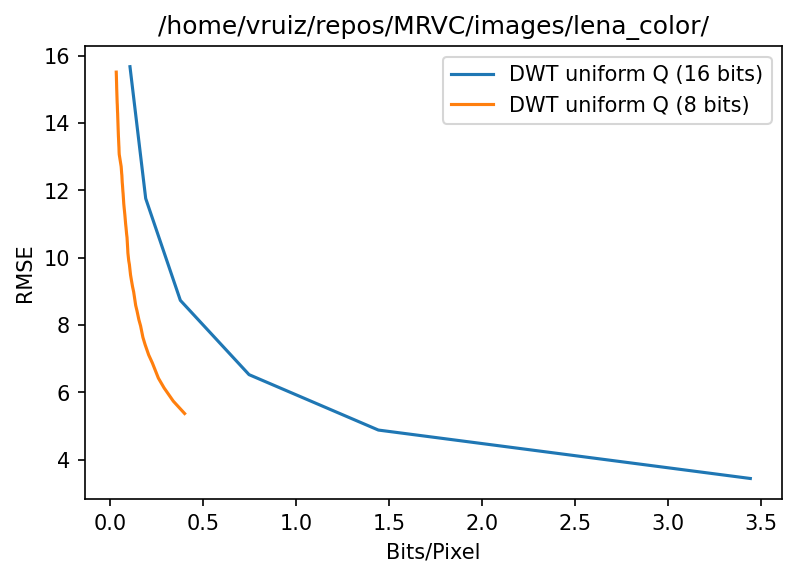

In [19]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DWT_constantQ), label=f"DWT uniform Q (16 bits)")
pylab.plot(*zip(*DWT_8b_constantQ), label=f"DWT uniform Q (8 bits)")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
#plt.xlim([0, 1])
pylab.show()

The glued representation is more efficient than the unglued one for low bit-rates.

### Compare

In [20]:
DCT_RD_points = []
with open("../YCoCg_2D_DCT_SQ/YCoCg_2D_DCT_SQ.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        DCT_RD_points.append((float(rate), float(_distortion)))

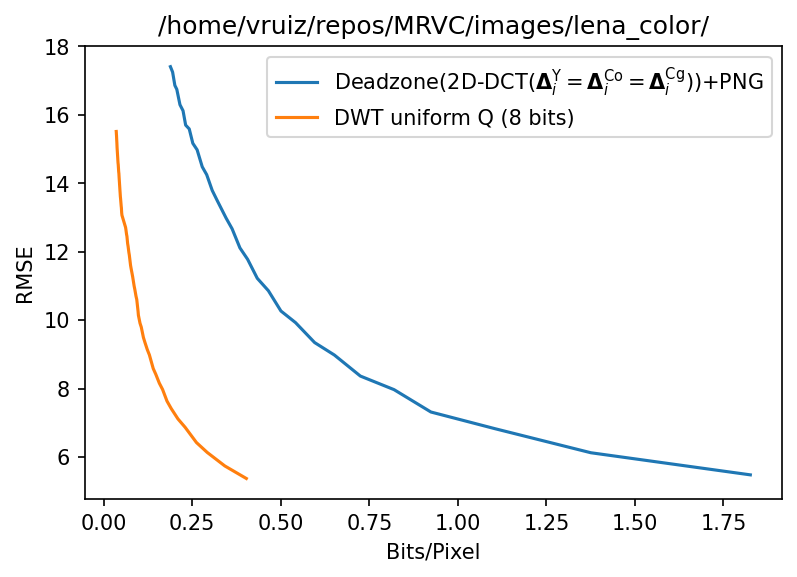

In [21]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DCT_RD_points), label=r"Deadzone(2D-DCT($\mathbf{\Delta}^{\mathrm{Y}}_i = \mathbf{\Delta}^{\mathrm{Co}}_i = \mathbf{\Delta}^{\mathrm{Cg}}_i)$)+PNG")
pylab.plot(*zip(*DWT_8b_constantQ), label=f"DWT uniform Q (8 bits)")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
#plt.xlim([0, 1])
pylab.show()

In [22]:
JPEG_RD_points = []
with open(HOME + "/repos/JPEG/JPEG.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        JPEG_RD_points.append((float(rate), float(_distortion)))

In [23]:
JPEG2K_RD_points = []
with open(HOME + "/repos/JPEG2000/JPEG2000.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        JPEG2K_RD_points.append((float(rate), float(_distortion)))

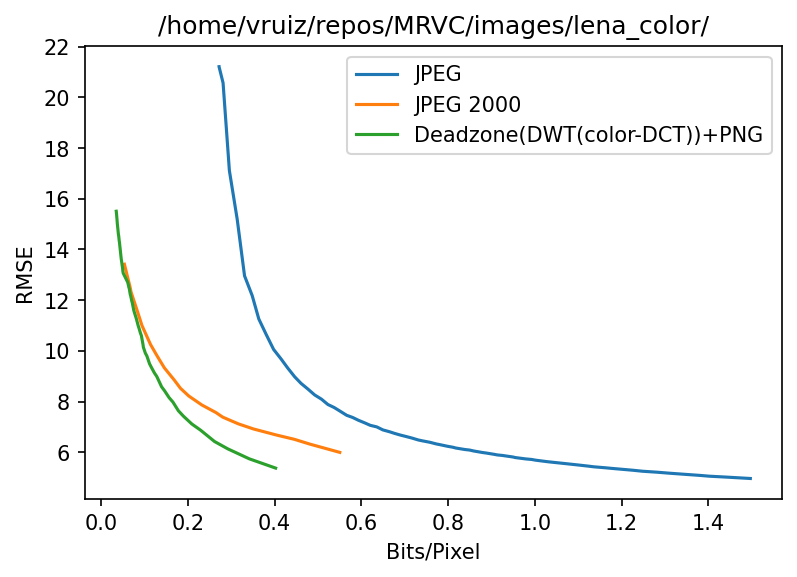

In [24]:
pylab.figure(dpi=150)
pylab.plot(*zip(*JPEG_RD_points), label=r"JPEG")
pylab.plot(*zip(*JPEG2K_RD_points), label=r"JPEG 2000")
pylab.plot(*zip(*DWT_8b_constantQ), label=f"Deadzone(DWT({YUV.name}))+PNG")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
#plt.xlim([0, 1])
pylab.show()

In [25]:
with open('YCoCg_2D_DWT_SQ.txt', 'w') as f:
    for item in DWT_8b_constantQ:
        f.write(f"{item[0]}\t{item[1]}\n")

In [ ]:
import time
while True:
    time.sleep(1)

## Uniform quantization using bi-orthogonal filters (TO-DO)

This procedure should be used when the YUV/DWT transform is not orthonormal (for example, when using the YCoCg color space and/or biorthogonal DWT filters). In this case we must consider the subband gains.

In [ ]:
print(wavelet)
#wavelet = 'bior3.5'
wavelet = 'db5'
img = image_3.read(test_image).astype(np.int16)
DWT.compute_gains(wavelet=wavelet, N_levels=N_levels, pixels_in_y=img.shape[0], pixels_in_x=img.shape[1])
# ...

## Finally ... can we increase the RD performance using RDO?

Let's do that, for a given RD point, the subband-components contribute (in general, approximately) the same to que quality of the reconstruction.

Algorithm:
1. Read the image.
2. Transform it to the YCoCg domain.
3. Transform each component to the DWT domain.
4. Estimate the RD curve for each subband-component.
5. Compute the slope of each step of each curve and put all the tuples (slopes, quantization steps, subband number) in the same list.
6. Sort the previous list by the slope field.
7. Compute the RD curve that progressively uses descending slopes.

### Read the image and move it to the 0-mean YCoCg domain.

In [ ]:
img = image_3.read(test_image, 0)
YUV_img = YUV.from_RGB(img.astype(np.int16))
avgs = [np.average(YUV_img[..., c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])

### Compute the 2D-DWT

In [ ]:
decom = DWT.analyze(YUV_img, wavelet, N_levels)

### Create a list of RD points for each RD curve (subband-component) and the corresponding lists of RD slopes between these points
There is a RD curve per subband-component. The first coordinate of each point is the rate and the second coordinate is the corresponding distortion.
For rate=0, the RMSE is the energy of the subband-component.
Notice that:
1. We have considered that the YUV/DWT transform is orthogonal and therefore, the distortion of the recontructed image can be estimated in the transform domain.
2. The slope cannot be computed for the first point of each RD curve.

In [ ]:
RD_points = []
RD_slopes = []
for _c in range(N_components):
    sbc = decom[0][..., _c]
    RD_points.append([(0, information.average_energy(sbc))]) # Work with RMSE's that are average distortions
    RD_slopes.append([])
level = N_levels - 1
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            sbc = sb[..., _c]
            sbc_avg_energy = information.average_energy(sbc)
            # The first point of each RD curve has a maximum distortion equal
            # to the energy of the subband and a rate = 0
            RD_points.append([(0, sbc_avg_energy)])
            RD_slopes.append([])
    level -= 1

In [ ]:
print("subband-component, RD-point")
for _i,_j in enumerate(RD_points):
    print(_i,_j)
    if not ((_i+1) % 3):
        print('')

#### Populate the rest of points of each curve

In [ ]:
# Subband LL
sbc_number = 0
for _c in range(N_components):
    sbc = decom[0][..., _c]
    Q_step_number = 0
    for Q_step in Q_steps:
        sbc_k = Q.quantize(sbc, Q_step)
        sbc_dQ = Q.dequantize(sbc_k, Q_step)
        RMSE = distortion.RMSE(sbc, sbc_dQ)
        #print(sbc.max(), sbc.min(), sbc_dQ.max(), sbc_dQ.min())
        #BPP = image_1.write((sbc_k + 128).astype(np.uint8), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
        BPP = image_1.write((sbc_k + 32768).astype(np.uint16), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
        #BPP = information.entropy(sbc_k.astype(np.int16).flatten())
        point = (BPP, RMSE)
        RD_points[sbc_number].append(point)
        delta_BPP = BPP - RD_points[_c][Q_step_number][0]
        delta_RMSE = RD_points[_c][Q_step_number][1] - RMSE
        if delta_BPP > 0:
            slope = delta_RMSE/delta_BPP
        else:
            slope = 0
        print(f"sbc_number={sbc_number} Q_step={Q_step} BPP={point[0]} RMSE={point[1]} slope={slope}")
        if slope > 0:
            RD_slopes[_c].append((Q_step, slope, _c))
        Q_step_number += 1
    sbc_number += 1

# Rest of subbands
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            sbc = sb[..., _c]
            Q_step_number = 0
            for Q_step in Q_steps:
                sbc_k = Q.quantize(sbc, Q_step)
                sbc_dQ = Q.dequantize(sbc_k, Q_step)
                RMSE = distortion.RMSE(sbc, sbc_dQ)
                #BPP = image_1.write((sbc_k + 128).astype(np.uint8), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
                BPP = image_1.write((sbc_k + 32768).astype(np.uint16), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
                #sbc_BPP = information.entropy(sbc_k.astype(np.int16).flatten())
                point = (BPP, RMSE)
                RD_points[sbc_number].append(point)
                delta_BPP = BPP - RD_points[sbc_number][Q_step_number][0]
                delta_RMSE = RD_points[sbc_number][Q_step_number][1] - RMSE
                if delta_BPP > 0:
                    slope = delta_RMSE/delta_BPP
                else:
                    slope = 0
                print(f"sbc_number={sbc_number} Q_step={Q_step} BPP={point[0]} RMSE={point[1]} slope={slope}")
                if slope > 0:
                    RD_slopes[sbc_number].append((Q_step, slope, sbc_number))
                Q_step_number += 1
            sbc_number += 1

In [ ]:
print("(BPP, RMSE)")
for _i, _j in enumerate(RD_points):
    print(_i, _j)
    if not ((_i+1) % 3):
        print('')

In [ ]:
print("subband-component, (Q_step, slope, subband-component number)")
for _i, _j in enumerate(RD_slopes):
    print(_i, _j)
    if not ((_i+1) % 3):
        print('')

## Remove points that do not belong to the convex-hull
Remove those points of each subband-component that do not satisfy that the slope is higher than the next point of the curve. 

In [ ]:
def filter_slopes(slopes):
    filtered_slopes = []
    slopes_iterator = iter(slopes)
    prev = next(slopes_iterator)
    for curr in slopes_iterator:
        if prev[1] < curr[1]:
            print(f"deleted {prev}")
        else:
            filtered_slopes.append(prev)
        prev = curr
    filtered_slopes.append(prev)
    return filtered_slopes

filtered_slopes = []
for i in RD_slopes:
    filtered_slopes.append(filter_slopes(i))

In [ ]:
print("Q_step, slope, subband-component number")
for _i, _j in enumerate(filtered_slopes):
    print(_i, "---", _j)

### Put all the lists together

In [ ]:
single_list = []
for l in filtered_slopes:
    for i in l:
        single_list.append(i)

In [ ]:
print("(quantization step, slope, subband-component number)")
single_list

### Sort the list of quantization steps, slopes, and subband-components
By slopes.

In [ ]:
progression_of_deltas = sorted(single_list, key=lambda _x: _x[1])[::-1]

In [ ]:
print("(quantization step, slope, subband-component number)")
progression_of_deltas

In [ ]:
print("Total number of subband-components =", (N_levels*3+1)*N_components)

### Let's see the progression of quantization steps

In [ ]:
Q_steps_pattern = 3*[''] # There are 3 color components
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            Q_steps_pattern.append('')
            
for i, j in enumerate(progression_of_deltas):
    Q_steps_pattern[j[2]] = j[0]
    print(i, j, Q_steps_pattern)

In [ ]:
def show(d, s):
    c = 0
    for i in d[0]:
        print(s, i, end=' ')
        c += 1
        if c > 3:
            break
    for sr in d[1:]:
        for sb in sr:
            c = 0
            for i in sb:
                print(s, i, end=' ')
                c += 1
                if c > 3:
                    break
    print()

def _quantize(decom, Q_steps):
    decom_k = []
    decom_k.append(Q.quantize_components(decom[0], Q_steps[0:3]))
    for sr in decom[1:]:
        decom_k.append(Q.sr)
    print()
    return decom_k

def _dequantize(decom_k, Q_steps):
    decom_dQ = []
    decom_dQ.append(decom_k[0])
    for sr_k in decom_k[1:]:
        decom_dQ.append(sr_k)
    print()
    return decom_dQ
    
def quantize_components_uint16(x, Q_steps):
    '''Quantize each component of <x> using a quantization step per component.'''
    x_k = np.empty_like(x, dtype=np.int32)
    for c in range(x.shape[2]):
        x_k[..., c] = Q.quantize(x[..., c], Q_steps[c]) + 32768
    return x_k.astype(np.uint16)

def dequantize_components_uint16(x_k, Q_steps):
    '''Dequantize each component of <x_k> using an independent quantization step.'''
    x_dQ = np.empty_like(x_k, dtype=np.int32)
    for c in range(x_k.shape[2]):
        x_dQ[..., c] = Q.dequantize(x_k[..., c].astype(np.int32) - 32768, Q_steps[c])
    return x_dQ

def quantize(decom, Q_steps):
    '''Quantize and add 32768.'''
    decom_k = []
    #decom_k.append(decom[0])
    decom_k.append(quantize_components_uint16(decom[0], Q_steps[0:3]))
    #print(decom[0].max(), decom[0].min(), decom_k[0].max(), decom_k[0].min())
    sbc_number = 3
    for sr in decom[1:]:
        sr_k = []
        for sb in sr:
            sb_k = quantize_components_uint16(sb, Q_steps[sbc_number:sbc_number + 3])
            sr_k.append(sb_k)
            sbc_number += 3
        #decom_k.append(sr)
        decom_k.append(tuple(sr_k))
    return decom_k

def dequantize(decom_k, Q_steps):
    decom_dQ = []
    #decom_dQ.append(decom_k[0])
    decom_dQ.append(dequantize_components_uint16(decom_k[0], Q_steps[0:3]))
    sbc_number = 3
    for sr_k in decom_k[1:]:
        sr_dQ = []
        for sb_k in sr_k:
            sb_dQ = dequantize_components_uint16(sb_k, Q_steps[sbc_number:sbc_number + 3])
            sr_dQ.append(sb_dQ)
            sbc_number += 3
        #decom_dQ.append(sr_k)
        decom_dQ.append(tuple(sr_dQ))
    return decom_dQ
    
def quantize_sr(sr, Q_step):
    '''Quantize a spatial resolution of the DWT (3 multicomponent subbands) using
    3*N_components independent quantization steps'''
    return tuple([Q.quantize(i, Q_step) for i in sr])

def _quantize(decomposition, Q_steps):
    LL = decomposition[0]
    LL_k = np.empty_like(LL, dtype=np.int16)
    for _c in range(N_components):
        LLc = LL[..., _c]
        LL_k[..., _c] = LLc # Q.quantize(LLc, Q_steps[_c])
    decomposition_k = [LL_k]
    sbc_number = 3
    for sr in decomposition[1:]:
        #print("sr", len(sr))
        sr_k = []
        for sb in sr:
            sbc_k = np.empty_like(sb)
            for _c in range(N_components):
                sbc = sb[..., _c]
                #print(len(Q_steps), sbc_number)
                sbc_k[..., _c] = sbc # Q.quantize(sbc, Q_steps[sbc_number])
                #sbc_k = Q.quantize(sbc, Q_steps[sbc_number])
                sbc_number += 1
            sr_k.append(sbc_k)
        decomposition_k.append(tuple(sr_k))
    return decomposition
    #return decomposition_k

def _dequantize(decomposition_k, Q_steps):
    LL_k = decomposition_k[0]
    LL_dQ = np.empty_like(LL_k).astype(np.float64)
    for _c in range(N_components):
        LLc_k = LL_k[..., _c]
        LL_dQ[..., _c] = LLc_k# Q.dequantize(LLc_k, Q_steps[_c])
    decomposition_dQ = [LL_dQ]
    sbc_number = 3
    for sr_k in decomposition_k[1:]:
        sr_dQ = []
        #print("sr_k", len(sr_k))
        for sb_k in sr_k:
            sbc_dQ = np.empty_like(sb_k).astype(np.float64)
            for _c in range(N_components):
                sbc_k = sb_k[..., _c]
                #print(len(Q_steps), sbc_number)
                sbc_dQ[..., _c] = sbc_k #Q.dequantize(sbc_k, Q_steps[sbc_number])
                sr_dQ.append(sbc_dQ)
                sbc_number += 1
        decomposition_dQ.append(tuple(sr_dQ))
    return decomposition_k
    #return decomposition_dQ

def resolution_level(sb_number):
    '''Resolution level in decomposition.'''
    if sb_number > 0:
        return ((sb_number - 1) // 3) + 1
    else:
        return 0
    
def subband_index(sb_number):
    '''Subband index in resolution level.'''
    if sb_number > 0:
        return (sb_number % 3) - 1
    else:
        return 0

### Find the optimal RD curve

In [ ]:
DWT_RDO_16_glued = []

# Initially all the quantization steps structure are "infinite"=10^4.
Q_steps_pattern = 3*[10**4] # There are 3 color components
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            Q_steps_pattern.append(10**4)

slope_index = 0
for s in progression_of_deltas:
    sbc_number = s[2]
    Q_steps_pattern[sbc_number] = s[0]
    decom_k = quantize(decom, Q_steps_pattern)
    BPP = (DWT.write_glued(decom_k, f"/tmp/optimal_{slope_index}_", 0)[0]*8)/YUV_img.size
    decom_dQ = dequantize(decom_k, Q_steps_pattern)
    YUV_img_dQ = DWT.synthesize(decom_dQ, wavelet, N_levels)
    for c in range(3):
        YUV_img_dQ[..., c] += int(avgs[c])
    img_dQ = np.clip(YUV.to_RGB(YUV_img_dQ), a_min=0, a_max=255)
    RMSE = distortion.RMSE(img, img_dQ)
    print(f"Q_steps_pattern={Q_steps_pattern} BPP={BPP} RMSE={RMSE}")
    #if not slope_index % 10:
    #    image_3.show(img_dQ.astype(np.uint8), f"Q_step={Q_step} BPP={BPP:3.2f} RMSE={RMSE:4.2f}")
    DWT_RDO_16_glued.append((BPP, RMSE))
    slope_index += 1

In [ ]:
DWT_RDO_16_glued

In [ ]:
DCT_RDO = []
with open(HOME + "/Sistemas-Multimedia.github.io/milestones/07-DCT/DCT_RDO.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        DCT_RDO.append((float(rate), float(_distortion)))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DWT_8b_constantQ), label=f"{YUV.name}/{N_levels}-{wavelet_name} (glued, 8 bits, without RDO)")
pylab.plot(*zip(*DWT_RDO_16_glued), label=f"{YUV.name}/{N_levels}-{wavelet_name} (glued, 16 bits, with RDO)")
pylab.plot(*zip(*DCT_RDO), label="YCoCg/8x8-DCT (with RDO)")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc="best")
pylab.show()

## Using unglued PNG images

### Read the image and move it to the 0-mean YCoCg domain.

In [ ]:
img = image_3.read(test_image, 0)
YUV_img = YUV.from_RGB(img.astype(np.int16))
avgs = [np.average(YUV_img[..., c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])

### Compute (the 8-bit) 2D-DWT

In [ ]:
decom = DWT.analyze(YUV_img, wavelet, N_levels)

### Create a list of RD points for each RD curve (subband-component) and the corresponding lists of RD slopes between these points

In [ ]:
RD_points = []
RD_slopes = []
for _c in range(N_components):
    sbc = decom[0][..., _c]#.astype(np.int32) << N_levels #* math.pow(2, N_levels)
    RD_points.append([(0, information.average_energy(sbc))]) # Work with RMSE's that are average distortions
    RD_slopes.append([])
level = N_levels - 1
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            sbc = sb[..., _c]#.astype(np.int32) << level #* math.pow(2, level)
            sbc_avg_energy = information.average_energy(sbc)
            # The first point of each RD curve has a maximum distortion equal
            # to the energy of the subband and a rate = 0
            RD_points.append([(0, sbc_avg_energy)])
            RD_slopes.append([])
    level -= 1

In [ ]:
print("subband-component, RD-point")
for _i,_j in enumerate(RD_points):
    print(_i,_j)
    if not ((_i+1) % 3):
        print('')

#### Populate the rest of points of each curve

In [ ]:
# Subband LL
sbc_number = 0
for _c in range(N_components):
    sbc = decom[0][..., _c]#.astype(np.int32) << N_levels #* math.pow(2, N_levels)
    Q_step_number = 0
    for Q_step in Q_steps:
        #_Q_step = compute_Q_step(Q_step, N_levels)
        sbc_k = Q.quantize(sbc, Q_step)
        sbc_dQ = Q.dequantize(sbc_k, Q_step)
        RMSE = distortion.RMSE(sbc, sbc_dQ)
        #print(sbc.max(), sbc.min(), sbc_dQ.max(), sbc_dQ.min())
        #BPP = image_1.write((sbc_k + 128).astype(np.uint8), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
        BPP = image_1.write((sbc_k + 32768).astype(np.uint16), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
        #BPP = information.entropy(sbc_k.astype(np.int16).flatten())
        point = (BPP, RMSE)
        RD_points[sbc_number].append(point)
        delta_BPP = BPP - RD_points[_c][Q_step_number][0]
        delta_RMSE = RD_points[_c][Q_step_number][1] - RMSE
        if delta_BPP > 0:
            slope = delta_RMSE/delta_BPP
        else:
            slope = 0#100**10
        print(f"sbc_number={sbc_number} Q_step={Q_step} BPP={point[0]} RMSE={point[1]} slope={slope}")
        #RD_slopes[_c].append((Q_step, slope, _c))
        #RD_slopes[_c].append((_Q_step, slope, _c))
        if slope > 0:
            RD_slopes[_c].append((Q_step, slope, _c))
        Q_step_number += 1
    sbc_number += 1

# Rest of subbands
level = N_levels - 1
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            sbc = sb[..., _c]#.astype(np.int32) << level #* math.pow(2, level)
            Q_step_number = 0
            for Q_step in Q_steps:
                #_Q_step = compute_Q_step(Q_step, level)
                sbc_k = Q.quantize(sbc, Q_step)
                sbc_dQ = Q.dequantize(sbc_k, Q_step)
                RMSE = distortion.RMSE(sbc, sbc_dQ)
                #BPP = image_1.write((sbc_k + 128).astype(np.uint8), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
                BPP = image_1.write((sbc_k + 32768).astype(np.uint16), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
                #sbc_BPP = information.entropy(sbc_k.astype(np.int16).flatten())
                point = (BPP, RMSE)
                RD_points[sbc_number].append(point)
                delta_BPP = BPP - RD_points[sbc_number][Q_step_number][0]
                delta_RMSE = RD_points[sbc_number][Q_step_number][1] - RMSE
                if delta_BPP > 0:
                    slope = delta_RMSE/delta_BPP
                else:
                    slope = 0
                print(f"sbc_number={sbc_number} Q_step={Q_step} BPP={point[0]} RMSE={point[1]} slope={slope}")
                if slope > 0:
                    RD_slopes[sbc_number].append((Q_step, slope, sbc_number))
                Q_step_number += 1
            sbc_number += 1
    level -= 1

In [ ]:
print("(BPP, RMSE)")
for _i, _j in enumerate(RD_points):
    print(_i, _j)
    if not ((_i+1) % 3):
        print('')

In [ ]:
print("subband-component, (Q_step, slope, subband-component number)")
for _i, _j in enumerate(RD_slopes):
    print(_i, _j)
    if not ((_i+1) % 3):
        print('')

## Remove points that do not belong to the convex-hull 

In [ ]:
def filter_slopes(slopes):
    filtered_slopes = []
    slopes_iterator = iter(slopes)
    prev = next(slopes_iterator)
    for curr in slopes_iterator:
        if prev[1] < curr[1]:
            print(f"deleted {prev}")
        else:
            filtered_slopes.append(prev)
        prev = curr
    filtered_slopes.append(prev)
    return filtered_slopes

filtered_slopes = []
for i in RD_slopes:
    filtered_slopes.append(filter_slopes(i))

### Put all the lists together

In [ ]:
single_list = []
for l in filtered_slopes:
    for i in l:
        single_list.append(i)

In [ ]:
print("(quantization step, slope, subband-component number)")
single_list

### Sort the list of quantization steps, slopes, and subband-components
By slopes.

In [ ]:
progression_of_deltas = sorted(single_list, key=lambda _x: _x[1])[::-1]

In [ ]:
print("(quantization step, slope, subband-component number)")
progression_of_deltas

In [ ]:
print("Total number of subband-components =", (N_levels*3+1)*N_components)

### Let's see the progression of quantization steps

In [ ]:
Q_steps_pattern = 3*[''] # There are 3 color components
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            Q_steps_pattern.append('')
            
for i, j in enumerate(progression_of_deltas):
    Q_steps_pattern[j[2]] = j[0]
    print(i, j, Q_steps_pattern)

In [ ]:
def quantize_components(x, Q_steps):
    '''Quantize each component of <x> using a quantization step per component.'''
    x_k = np.empty_like(x, dtype=np.int32)
    for c in range(x.shape[2]):
        x_k[..., c] = Q.quantize(x[..., c], Q_steps[c]) # + 128
    return x_k

def dequantize_components(x_k, Q_steps):
    '''Dequantize each component of <x_k> using an independent quantization step.'''
    x_dQ = np.empty_like(x_k, dtype=np.int32)
    for c in range(x_k.shape[2]):
        #x_dQ[..., c] = Q.dequantize(x_k[..., c].astype(np.uint32) - 128, Q_steps[c])
        x_dQ[..., c] = Q.dequantize(x_k[..., c], Q_steps[c])
    return x_dQ

def quantize(decom, Q_steps):
    decom_k = []
    #decom_k.append(decom[0])
    decom_k.append(quantize_components(decom[0], Q_steps[0:3]))
    sbc_number = 3
    for sr in decom[1:]:
        sr_k = []
        for sb in sr:
            sb_k = quantize_components(sb, Q_steps[sbc_number:sbc_number + 3])
            sr_k.append(sb_k)
            sbc_number += 3
        #decom_k.append(sr)
        decom_k.append(tuple(sr_k))
    return decom_k

def dequantize(decom_k, Q_steps):
    decom_dQ = []
    #decom_dQ.append(decom_k[0])
    decom_dQ.append(dequantize_components(decom_k[0], Q_steps[0:3]))
    sbc_number = 3
    for sr_k in decom_k[1:]:
        sr_dQ = []
        for sb_k in sr_k:
            sb_dQ = dequantize_components(sb_k, Q_steps[sbc_number:sbc_number + 3])
            sr_dQ.append(sb_dQ)
            sbc_number += 3
        #decom_dQ.append(sr_k)
        decom_dQ.append(tuple(sr_dQ))
    return decom_dQ

### Find the optimal RD curve

In [ ]:
DWT_RDO_16_unglued = []

# Initially all the quantization steps structure are "infinite"=10^4.
Q_steps_pattern = 3*[10**4] # There are 3 color components
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            Q_steps_pattern.append(10**4)

slope_index = 0
for s in progression_of_deltas:
    sbc_number = s[2]
    Q_steps_pattern[sbc_number] = s[0]
    decom_k = quantize(decom, Q_steps_pattern)
    disk_decom_k = [add_offset(decom_k[0])]
    for sr_k in decom_k[1:]:
        disk_sr_k = []
        for sb_k in sr_k:
            disk_sr_k.append(add_offset(sb_k))
        disk_decom_k.append(tuple(disk_sr_k))
    BPP = (DWT.write_unglued(disk_decom_k, f"/tmp/optimal_{slope_index}_", 0)[0]*8)/img.size
    #BPP = (write_compact_decomposition(decom_k, f"/tmp/optimal_{slope_index}_", 0)*8)/YUV_img.size
    #BPP = entropy(y_k)
    decom_dQ = dequantize(decom_k, Q_steps_pattern)
    YUV_img_dQ = DWT.synthesize(decom_dQ, wavelet, N_levels)
    for c in range(3):
        YUV_img_dQ[..., c] += int(avgs[c])
    img_dQ = np.clip(YUV.to_RGB(YUV_img_dQ), a_min=0, a_max=255)
    RMSE = distortion.RMSE(img, img_dQ)
    print(f"Q_steps_pattern={Q_steps_pattern} BPP={BPP} RMSE={RMSE}")
    #if not slope_index % 10:
    #    image_3.show(img_dQ.astype(np.uint8), f"Q_step={Q_step} BPP={BPP:3.2f} RMSE={RMSE:4.2f}")
    DWT_RDO_16_unglued.append((BPP, RMSE))
    slope_index += 1

In [ ]:
DWT_RDO_16_unglued

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DWT_8b_constantQ), label=f"{YUV.name}/{N_levels}-{wavelet_name} (glued, 8 bits, without RDO)")
pylab.plot(*zip(*DWT_RDO_16_glued), label=f"{YUV.name}/{N_levels}-{wavelet_name} (glued, 16 bits, with RDO)")
pylab.plot(*zip(*DWT_RDO_16_unglued), label=f"{YUV.name}/{N_levels}-{wavelet_name} (unglued, 16 bits, with RDO)")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc="best")
pylab.show()

## RDO using bi-orthogonal filters (TODO)

## JPEG2000 RD curve (and comparison) (TODO)

## Ignore the rest ...

In [ ]:
def __read_image(prefix):
    x = image_3.read(prefix, 0)
    if len(x.shape) == 2:
        extended_x = np.zeros(shape=(x.shape[0],  x.shape[1], 3), dtype=np.uint16) 
        extended_x[..., 0] = x
        return extended_x
    else:
        return x

def _write_compact_decomposition(decom, prefix, image_number):
    rows = decom[len(decom)-1][0].shape[0]*2
    cols = decom[len(decom)-1][0].shape[1]*2
    coms = decom[0].shape[2]
    image_shape = (rows, cols, coms)
    view = np.empty(image_shape, np.uint16)

    # LL subband
    view[0:decom[0].shape[0],
         0:decom[0].shape[1]] = (decom[0].astype(np.int32) + 32768).astype(np.uint16)

    for l in range(len(decom)-1):

        # LH
        view[0:decom[l+1][0].shape[0],
             decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] =\
                (decom[l+1][0].astype(np.int32) + 32768).astype(np.uint16)

        # HL
        view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
             0:decom[l+1][1].shape[1]] =\
                (decom[l+1][1].astype(np.int32) + 32768).astype(np.uint16)

        # HH
        view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
             decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] =\
                (decom[l+1][2].astype(np.int32) + 32768).astype(np.uint16)
            
    return image.write(view, prefix, image_3_number)
    
def write_compact_decomposition(decom, prefix, image_number):
    rows = decom[len(decom)-1][0].shape[0]*2
    cols = decom[len(decom)-1][0].shape[1]*2
    coms = decom[0].shape[2]
    image_shape = (rows, cols, coms)
    view = np.empty(image_shape, np.uint8)

    # LL subband
    view[0:decom[0].shape[0],
         0:decom[0].shape[1]] = (decom[0].astype(np.int16) + 128).astype(np.uint16)

    for l in range(len(decom)-1):

        # LH
        view[0:decom[l+1][0].shape[0],
             decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] =\
                (decom[l+1][0].astype(np.int16) + 128).astype(np.uint16)

        # HL
        view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
             0:decom[l+1][1].shape[1]] =\
                (decom[l+1][1].astype(np.int16) + 128).astype(np.uint16)

        # HH
        view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
             decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] =\
                (decom[l+1][2].astype(np.int16) + 128).astype(np.uint16)
            
    return image_3.write(view, prefix, image_number)

def read_compact_decomposition(prefix, image_number, N_levels):
    view = image.read(prefix, image_number)
    wavelet = pywt.Wavelet("Haar")
    decom = DWT.analyze(np.zeros_like(view), wavelet, N_levels)
    
    # LL subband
    decom[0][...] = view[0:decom[0].shape[0],
                         0:decom[0].shape[1]] - 32768
    
    for l in range(len(N_levels)):
        
        # LH
        decom[l+1][0] =\
            view[0:decom[l+1][0].shape[0],
                 decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] - 32668
            
        # HL
        decom[l+1][1] =\
            view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
                 0:decom[l+1][1].shape[1]] - 32768
            
        # HH
        decom[l+1][2] =\
            view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
                 decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] - 32768

    return decom



In [ ]:
# No me borres todvía (mira lo que tengo dentro)

img = image_3.read(test_image)
YUV_img = YUV.from_RGB(img.astype(np.int16))
avgs = [np.average(YUV_img[..., c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
decom = DWT.analyze(YUV_img, wavelet, N_levels)
DWT_RDO = []
# Initially all the quantization steps structure are "infinite"=10^4.
Q_steps_pattern = 3*[10**4] # There are 3 color components
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            Q_steps_pattern.append(10**4)
for s in progression_of_deltas:
    decom_8b = to_8bits(decom)
    LL_8b = decom_8b[0]
    _Q_step = compute_Q_step(Q_step, N_levels)
    LL_8b_k = Q.quantize(LL_8b, _Q_step) # Baybe bettter Q.get_indexes()
    decom_8b_k = [(LL_8b_k + 128).astype(np.uint8)]
    LL_8b_dQ = Q.dequantize(LL_8b_k, _Q_step) # Q.get_signal()
    decom_8b_dQ = [LL_8b_dQ]
    sbc_counter = 0
    level = N_levels - 1
    for sr_8b in decom_8b[1:]: # sr = spatial_resolution
        sr_8b_k = []
        sr_8b_dQ = []
        for sb_8b in sr_8b: # sb = subband
            _Q_step = compute_Q_step(Q_step, level)
            sb_8b_k = Q.quantize(sb_8b, _Q_step)
            sb_8b_dQ = Q.dequantize(sb_8b_k, _Q_step)
            sr_8b_k.append((sb_8b_k + 128).astype(np.uint8))
            sr_8b_dQ.append(sb_8b_dQ)
            sbc_counter += 1
        decom_8b_k.append(tuple(sr_8b_k))
        decom_8b_dQ.append(tuple(sr_8b_dQ))
        level -= 1
    BPP = (DWT.write_glued(decom_8b_k, f"/tmp/constant_{Q_step}_", 0)[0]*8)/YUV_img.size
    decom_dQ = to_16bits(decom_8b_dQ)
    YUV_img_dQ = DWT.synthesize(decom_dQ, wavelet, N_levels)
    for c in range(3):
        YUV_img_dQ[..., c] += int(avgs[c])
    img_dQ = YUV.to_RGB(YUV_img_dQ)
    img_dQ = np.clip(img_dQ, a_min=0, a_max=255).astype(np.uint8)
    RMSE = distortion.RMSE(img, img_dQ)
    print(f"Q_step={Q_step} BPP={BPP} RMSE={RMSE}")
    DWT_RDO.append((BPP, RMSE))
    #image_3.show(img_dQ.astype(np.uint8), f"Q_step={Q_step} BPP={BPP:3.2f} RMSE={RMSE:4.2f}")

In [ ]:
def ___estimate_codestream_len(x, prefix):
    empty_x = np.zeros_like(x)
    real_BPP = image_1.write(x.astype(np.uint8), prefix)
    empty_BPP = image_1.write(empty_x.astype(np.uint8), prefix)
    return real_BPP - empty_BPP
    #return information.entropy(x.astype(np.int16).flatten())*x.size

### Remove 0-slopes
In each subband-component, remove those zero contributions to the quality.

In [ ]:
def filter_0_slopes(slopes):
    filtered_slopes = []
    for i in slopes:
        if i[1]!= 0:
            filtered_slopes.append(i)
        else:
            print(f"removed {i}")
    return filtered_slopes

filtered_slopes = []
for i in RD_slopes:
    filtered_slopes.append(filter_0_slopes(i))

## Remove points that do not belong to the convex-hull
Remove those points of each subband-component that do not satisfy that the slope is higher than the next point of the curve. 

In [ ]:
def filter_slopes(slopes):
    filtered_slopes = []
    slopes_iterator = iter(slopes)
    prev = next(slopes_iterator)
    for curr in slopes_iterator:
        if prev[1] < curr[1]:
            print(f"deleted {prev}")
        else:
            filtered_slopes.append(prev)
        prev = curr
    filtered_slopes.append(prev)
    return filtered_slopes

filtered_slopes = []
for i in RD_slopes:
    filtered_slopes.append(filter_slopes(i))

In [ ]:
print("Q_step, slope, subband-component number")
for _i, _j in enumerate(filtered_slopes):
    print(_i, "---", _j)

In [ ]:
# Show the slopes
RD_slopes_without_sbc_index = []
#RD_slopes_without_sbc_index.append([])
for _c in range(N_components):
    RD_slopes_without_sbc_index.append([])
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            RD_slopes_without_sbc_index.append([])
for Q_step in range(len(Q_steps)):
    RD_slopes_without_sbc_index[0].append(RD_slopes[0][Q_step][0:2])
sbc_number = 3
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            for Q_step in range(len(Q_steps)):
                RD_slopes_without_sbc_index[sbc_number].append(RD_slopes[sbc_number][Q_step][0:2])
            sbc_number += 1
print(RD_slopes_without_sbc_index[0])
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_slopes_without_sbc_index[0]), label="0", marker=0)
for sbc_number in range(10):
    pylab.plot(*zip(*RD_slopes_without_sbc_index[sbc_number]), label=f"{sbc_number}", marker=sbc_number)
pylab.title("Slopes of the RD curves of the subbands")
pylab.xlabel("Q_step")
pylab.ylabel("Slope")
plt.legend(loc="best")
pylab.show()

In [ ]:
def compute_Q_step(Q_step, level):
    #step = int(math.ceil(Q_step * math.pow(2, N_levels)))
    step = int(math.ceil(Q_step * math.pow(2, level)))
    print(f"compute_Q_step: Q_step={Q_step} level={level} step={step}")
    return step

In [ ]:
Q_steps = [16, 8, 4, 2, 1, 0.5, 0.25, 1/8, 1/16]
# Use "uniform" quantization and write_unglued()
#img = image_3.read(test_image)
#YUV_img = YUV.from_RGB(img.astype(np.int16) - 128)

img = image_3.read(test_image).astype(np.int16)
YUV_img = YUV.from_RGB(img)
avgs = [np.average(YUV_img[..., c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
decom = DWT.analyze(YUV_img, wavelet, N_levels)

image_domain_DWT_RD_points2 = []
for Q_step in Q_steps:
    LL = decom[0]
    print('LL')
    _Q_step = compute_Q_step(Q_step, N_levels)
    #LL_k = Q.quantize(LL, Q_step << N_levels) # Baybe bettter Q.get_indexes()
    LL_k = Q.quantize(LL, _Q_step) # Baybe bettter Q.get_indexes()
    #LL_k = Q.quantize(LL, Q_step) # Baybe bettter Q.get_indexes()
    #assert (-128 <= LL_k).all() and (LL_k <= 127).all(), print("LL", Q_step, np.unique(LL_k))
    #LL_dQ = Q.dequantize(LL_k, Q_step << N_levels) # Q.get_signal()
    LL_dQ = Q.dequantize(LL_k, _Q_step) # Q.get_signal()
    #LL_dQ = Q.dequantize(LL_k, Q_step) # Q.get_signal()
    if drange(LL_k) < 256:
        decom_k = [(LL_k + 128).astype(np.uint8)]
    else:
        decom_k = [(LL_k + 32768).astype(np.uint16)]
    decom_dQ = [LL_dQ]
    #dist = distortion.RMSE(LL, LL_dQ)
    #RMSE = (dist * LL.size)/x.size
    #print(gains[0], dist, gains[0] * dist, RMSE)
    #for i in range(4):
    #    for j in range(4):
    #        print(LL[i, j], LL_dQ[i, j])
    sbc_counter = 0
    levels_counter = N_levels - 1
    for sr in decom[1:]: # sr = spatial_resolution
        sr_k = []
        sr_dQ = []
        for sb in sr: # sb = subband
            #print(RMSE)
            #sb_k = Q.quantize(sb, Q_step << levels_counter)
            print(f"levels_counter={levels_counter}")
            _Q_step = compute_Q_step(Q_step, levels_counter)
            sb_k = Q.quantize(sb, _Q_step)
            #sb_k = Q.quantize(sb, Q_step)
            #assert (-128 <= sb_k).all() and (sb_k <= 127).all(), print(sbc_counter, np.unique(sb_k))
            #sb_dQ = Q.dequantize(sb_k, Q_step << levels_counter)
            sb_dQ = Q.dequantize(sb_k, _Q_step)
            #sb_dQ = Q.dequantize(sb_k, Q_step)
            if drange(sb_k) < 256:
                sr_k.append((sb_k + 128).astype(np.uint8))
            else:
                sr_k.append((sb_k + 32768).astype(np.uint16))
            sr_dQ.append(sb_dQ)
            #dist = distortion.RMSE(sb, sb_dQ)
            #print(gains[counter], dist, gains[counter] * dist, RMSE)
            #MSE += (dist * sb.size)/x.size
            sbc_counter += 1
        decom_k.append(tuple(sr_k))
        decom_dQ.append(tuple(sr_dQ))
        levels_counter += 1
    #subbands_info(decom_dQ)
    #BPP = (write_compact_decomposition(decom_k, f"/tmp/constant_{Q_step}_", 0)*8)/YUV_img.size
    #shifted_decom_k = DWT.add(decom_k, 128)
    #shifted_decom_k = DWT.set_type(decom_k, np.uint8)
    #BPP = (DWT.write(decom_k, f"/tmp/constant_{Q_step}_", 0)[0]*8)/YUV_img.size
    BPP = (DWT.write_unglued(decom_k, f"/tmp/constant_{Q_step}_", 0)[0]*8)/YUV_img.size
    YUV_img_dQ = DWT.synthesize(decom_dQ, wavelet, N_levels)

    for c in range(3):
        YUV_img_dQ[..., c] += int(avgs[c])
    img_dQ = YUV.to_RGB(YUV_img_dQ)
    img_dQ = np.clip(img_dQ, a_min=0, a_max=255).astype(np.uint8)

    #img_dQ = np.clip(YUV.to_RGB(YUV_img_dQ), a_min=-128, a_max=127) + 128
    #img_dQ = YUV.to_RGB(YUV_img_dQ) + 128
    #clipped_img_dQ = np.clip(img_dQ, a_min=0, a_max=255)
    #RMSE = distortion.RMSE(img, clipped_img_dQ)
    RMSE = distortion.RMSE(img, img_dQ)
    print(f"_Q_step={_Q_step} BPP={BPP} RMSE={RMSE}")
    image_domain_DWT_RD_points2.append((BPP, RMSE))
    image_3.show(img_dQ.astype(np.uint8), f"Reconstructed image (Q_step={Q_step})")

## Lossy compression

In [ ]:
img = image_3.read(test_image).astype(np.int16)
YUV_img = YUV.from_RGB(img)
avgs = [np.average(YUV_img[...,c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
decom = DWT.analyze(YUV_img, wavelet, N_levels)
decom8 = _8bits_me(decom)
decom8_ = DWT.add(decom8, 128)
decom8__ = DWT.set_type(decom8_, np.uint8)
output_len, slices = DWT.write_glued(decom8__, "/tmp/lossless", 0)
_decom8 = DWT.read_glued(slices, "/tmp/lossless", 0)
_decom8 = inverse_8bits_me(_decom8)
_decom8 = DWT.add(_decom8, -128)
_YUV_img8 = DWT.synthesize(_decom8, wavelet, N_levels)
for c in range(3):
    _YUV_img[..., c] += int(avgs[c])
_img = YUV.to_RGB(_YUV_img).astype(np.uint8)
image_3.show(_img)

In [ ]:
image_3.show(img - _img + 128)

In [ ]:
image_3.show(image_3.normalize(img - _img + 128))

In [ ]:
subbands_info(decom8)

### Quantization steps

The high dynamic range of the wavelet coefficients dificults the use 8-bit RGB PNG encoding, which is more compact that the 16-bit version. At this point, we have basically two alternatives:
1. Use a set of high enough quantization steps to keep the quantization indexes into 8 bits. However, notice that this probably is going to ignore most of the information of the high-frequency subbands because the amplitude of their coefficients are smaller than the smaller quantization step.
2. If the quality provided by the smaller quantization step is not enough, the unencoded (least significant) bit-planes of the coefficients can be compressed in a second 8-bit PNG image. TO-DO.
3. Check the dynamic range of the quantization idexes and if is larger than [-128, 127] use 16 bpps.

Notice that the smaller quantization step dependens on several factors:
1. The wavelet.
2. The number of levels.
3. The image content.

In [ ]:
#Q_steps = [4096, 2048, 1024, 512, 256, 128]
#Q_steps = [256, 128, 64, 32, 16]
#Q_steps = [64, 32, 16]
Q_steps = [32, 16, 8, 4, 2, 1, 0.5]
#Q_steps = [2]

## Uniform quantization vs optimal quantization

As we did with the DCT, let's compare both types of quantization in the RD space. Steps:

1. Compute the RD slope of each subband for a set of quantization steps. For this we will suppose that the subbands are independent (the DWT is orthogonal), measuring the distortion in the wavelet domain.
2. Sort the slopes. This will determine the optimal progression of quantization steps (which subband to incorporate more data to the code-stream, progressively).
3. Compute the distortion in the image domain for each bit-rate. Notice that this information should match with the privided by the step 1 (measuring the distortion in the wavelet domain). However, we prefer to computate the distortion in the image domain because the transform does not need to be orthogonal.

 Read the image, move to the YUV domain, and compute the DWT.

In [ ]:
xx = read_image(test_image)
x = YUV.from_RGB(xx.astype(np.int16) - 128)
y = DWT.analyze(x, wavelet, N_levels)

For each subband, we populate:
1. A list of RD points, and
2. A list of RD slopes with these points, indicanting also the corresponding quantization step and subband.

Remember that we have a RD point for each quantization step for each subband. The first dimension of these lists is indexed the subband, and the second dimension is indexed by the quantization step.

In [ ]:
# For BPP=0, the RMSE is the energy of the subband. No slope can be computed for the first point.
RD_points = [[(0, information.energy(y[0]) / y[0].size)]] # Work with RMSE's that are average distortions
RD_slopes = [[]]
for sr in y[1:]:
    for sb in sr:
        sb_avg_energy = information.energy(sb) / sb.size
        # The first point of each RD curve has a maximum distortion equal
        # to the energy of the subband and a rate = 0
        RD_points.append([(0, sb_avg_energy)])
        RD_slopes.append([])

for i,j in enumerate(RD_points):
    print(i,j)
    
for i,j in enumerate(RD_slopes):
    print(i,j)

In [ ]:
# Now populate the rest of points of each subband

# Subband LL
sb_number = 0
sb = y[0]
Q_step_number = 0
for Q_step in Q_steps:
    print(Q_steps)
    sb_k = Q.quantize(sb, Q_step)
    sb_dQ = Q.dequantize(sb_k, Q_step)
    sb_RMSE = distortion.RMSE(sb, sb_dQ)
    sb_BPP = information.PNG_BPP((sb_k.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
    #sb_BPP = information.entropy(sb_k.astype(np.int16).flatten())
    RD_points[sb_number].append((sb_BPP, sb_RMSE))
    delta_BPP = sb_BPP - RD_points[sb_number][Q_step_number][0]
    delta_RMSE = RD_points[sb_number][Q_step_number][1] - sb_RMSE
    if delta_BPP > 0:
        slope = delta_RMSE/delta_BPP
    else:
        slope = 0
    RD_slopes[sb_number].append((Q_step, slope, (sb_number)))
    Q_step_number += 1

print(N_levels)
    
for i,j in enumerate(RD_points):
    print(i, "---", j)
    
for i,j in enumerate(RD_slopes):
    print(i, "---", j)

In [ ]:
sb_number = 1
for sr in y[1:]:
    for sb in sr:
        Q_step_number = 0
        for Q_step in Q_steps:
            sb_k = Q.quantize(sb, Q_step)
            sb_dQ = Q.dequantize(sb_k, Q_step)
            sb_RMSE = distortion.RMSE(sb, sb_dQ)
            sb_BPP = information.PNG_BPP((sb_k.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
            #sb_BPP = information.entropy(sb_k.astype(np.int16).flatten())
            RD_points[sb_number].append((sb_BPP, sb_RMSE))
            delta_BPP = sb_BPP - RD_points[sb_number][Q_step_number][0]
            delta_RMSE = RD_points[sb_number][Q_step_number][1] - sb_RMSE
            if delta_BPP > 0:
                slope = delta_RMSE/delta_BPP
            else:
                slope = 9^9
            print(sb_number, len(y))
            RD_slopes[sb_number].append((Q_step, slope, (sb_number)))
            Q_step_number += 1
        sb_number += 1
        
for i,j in enumerate(RD_points):
    print(i, "---", j)
    
for i,j in enumerate(RD_slopes):
    print(i, "---", j)

In [ ]:
RD_slopes

In [ ]:
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_points[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_points[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("RD curves of the subbands")
    pylab.xlabel("Bits/Pixel")
    pylab.ylabel("RMSE")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_points[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_points[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("RD curves of the subbands")
    pylab.xlabel("Bits/Pixel")
    pylab.ylabel("RMSE")
    pylab.yscale("log")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
RD_slopes_without_sb_index = []
RD_slopes_without_sb_index.append([])
for sr in y[1:]:
    for sb in sr:
        RD_slopes_without_sb_index.append([])
for Q_step in range(len(Q_steps)):
    RD_slopes_without_sb_index[0].append(RD_slopes[0][Q_step][0:2])
sb_number = 1
for sr in y[1:]:
    for sb in sr:
        for Q_step in range(len(Q_steps)):
            RD_slopes_without_sb_index[sb_number].append(RD_slopes[sb_number][Q_step][0:2])
        sb_number += 1
print(RD_slopes_without_sb_index[0])
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_slopes_without_sb_index[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_slopes_without_sb_index[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("Slopes of the RD curves of the subbands")
    pylab.xlabel("Q_step")
    pylab.ylabel("Slope")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_slopes_without_sb_index[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_slopes_without_sb_index[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("Slopes of the RD curves of the subbands")
    pylab.xlabel("Q_step")
    pylab.ylabel("Slope")
    pylab.yscale("log")
    plt.legend(loc="best")
    pylab.show()

It can be seen that the slopes of the curves are quite similar, but the LL subband is somewhat steeper.

Let's sort the slopes.

In [ ]:
single_list = []
for Q_step in range(len(Q_steps)):
    single_list.append(tuple(RD_slopes[0][Q_step]))
sb_number = 1
for sr in y[1:]:
    for sb in sr:
        for Q_step in range(len(Q_steps)):
            single_list.append(tuple(RD_slopes[sb_number][Q_step]))
        sb_number += 1
sorted_slopes = sorted(single_list, key=lambda x: x[1])[::-1]

In [ ]:
sorted_slopes

In [ ]:
def quantize(decomposition, Q_steps):
    #print(Q_steps)
    LL = decomposition[0]
    LL_k = Q.quantize(LL, Q_steps[0])
    decomposition_k = [LL_k]
    sb_number = 1
    for sr in decomposition[1:]:
        sr_k = []
        for sb in sr:
            #print(sb_number)
            sb_k = Q.quantize(sb, Q_steps[sb_number])
            sr_k.append(sb_k)
            sb_number += 1
        decomposition_k.append(tuple(sr_k))
    return decomposition_k

def dequantize(decomposition_k, Q_steps):
    LL_k = decomposition_k[0]
    LL_dQ = Q.dequantize(LL_k, Q_steps[0])
    decomposition_dQ = [LL_dQ]
    sb_number = 1
    for sr_k in decomposition_k[1:]:
        sr_dQ = []
        for sb_k in sr_k:
            sb_dQ = Q.dequantize(sb_k, Q_steps[sb_number])
            sr_dQ.append(sb_dQ)
            sb_number += 1
        decomposition_dQ.append(tuple(sr_dQ))
    return decomposition_dQ

def resolution_level(sb_number):
    '''Resolution level in decomposition.'''
    if sb_number > 0:
        return ((sb_number - 1) // 3) + 1
    else:
        return 0
    
def subband_index(sb_number):
    '''Subband index in resolution level.'''
    if sb_number > 0:
        return (sb_number % 3) - 1
    else:
        return 0

In [ ]:
optimal_RD_points = []
#y_prog = DWT.analyze(np.zeros_like(x), wavelet, N_levels)
#print(len(y_prog))
Q_steps_by_subband = [9**9]
#for sr in y_prog[1:]:
for sr in y[1:]:
    #print(len(sr))
    for sb in sr:
        Q_steps_by_subband.append(9**9)
#print(Q_steps_by_subband)
slope_index = 0
for s in sorted_slopes:
    sb_number = s[2]
    #print("sb_number", sb_number)
    Q_steps_by_subband[sb_number] = s[0]
    #print(sb_number, Q_steps_by_subband[sb_number])
    #y_prog[resolution_level(sb_number)][subband_index(sb_number)] = y[resolution_level(sb_number)][subband_index(sb_number)]
    #y_k = quantize(y_prog, Q_steps_by_subband)
    y_k = quantize(y, Q_steps_by_subband)
    BPP = (write_compact_decomposition(y_k, f"/tmp/optimal_{slope_index}_", 0)*8)/xx.size
    #BPP = entropy(y_k)
    slope_index += 1
    y_dQ = dequantize(y_k, Q_steps_by_subband)
    z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
    zz_dQ = np.clip(YUV.to_RGB(z_dQ), a_min=-128, a_max=127) + 128
    RMSE = distortion.RMSE(xx, zz_dQ)
    print(f"{Q_steps_by_subband} {BPP} {RMSE}")
    optimal_RD_points.append((BPP, RMSE))
    #image_3.show_RGB_image(zz_dQ, f"Reconstructed image (Q_step={Q_step})")

In [ ]:
optimal_RD_points

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DWT_points), label="Uniform quantization")
pylab.plot(*zip(*optimal_RD_points), label="Optimal quantization")
#pylab.plot(*zip(*JPEG_RD_points), label="JPEG")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc="best")
pylab.show()

# .......

ESTE PASO NO ES NECESARIO: Compute the average energy of the image and the decomposition.

In [ ]:
def energy(decomposition):
    accumulated_energy = information.energy(decomposition[0])
    for sr in y[1:]:
        for sb in sr:
            accumulated_energy += information.energy(sb)
    return accumulated_energy

In [ ]:
xx = read_image(test_image).astype(np.int16) - 128
#xx = np.full(shape=(512, 512, 3), fill_value=100) - 128
x = YUV.from_RGB(xx)
y = DWT.analyze(x, wavelet, N_levels)
image_energy = information.average_energy(x)
print(image_energy)
print(energy(y)/x.size)

## Transform gains

This information measures whether the transform amplifies or attenuates the signal. If the forward transform amplifies the signal, the energy of the decomposition will be larger than the energy of the original signal, and viceversa. The same idea can be applied to the inverse transform.

In [ ]:
x = np.full(shape=(512, 512, 3), fill_value=1)
x_energy = information.energy(x)
y = DWT.analyze(x, wavelet, N_levels)
decom_energy = information.energy(y[0])
z = DWT.synthesize(y, wavelet, N_levels)
for sr in y[1:]:
    for sb in sr:
        decom_energy += information.energy(sb)
z_energy = information.energy(z)
print(wavelet)
print("Energy of the original image:", x_energy)
print("Energy of the decomposition:", decom_energy)
print("Energy of the reconstucted image:", z_energy)
print("Average energy of the original image", x_energy / x.size)
print("Average energy of the decomposition:", decom_energy / x.size)
print("Average energy of the reconstructed image:", z_energy / x.size)

As it can be seen, the transform is energy preserving, which means that we the distortion generated by quantization is the same in the image and the wavelet domains.

## Subband gains

All the wavelet transforms implemented by PyWavelets are unitary (preserve the energy). However, this not means that the subbands have the same gain. We can determine the subbands gain of the inverse transform giving a fixed amount of energy to each subband and computing the energy of the inverse transform of the decomposition. Finally, considering that the inverse transform has a gain of one, the gains are scaled to sum 1.

We are specially interested in the subband gains, considering the inverse transform, because in the compression process the subbands are quantized, and the quantization error is scaled by the gain of the subbands.

In [ ]:
gains = []
x = np.zeros(shape=(512, 512, 3))
y = DWT.analyze(x, wavelet, N_levels)
coeff_value = y[0].size
y[0][...] = coeff_value/y[0].size
z = DWT.synthesize(y, wavelet, N_levels)
gains.append(distortion.energy(z))
prev_sb = y[0]
for sr in y[1:]:
    for sb in sr:
        prev_sb[...] = 0.0
        sb[...] = coeff_value/sb.size
        z = DWT.synthesize(y, wavelet, N_levels)
        gains.append(distortion.energy(z))
        prev_sb = sb
        
x = np.empty(shape=(512, 512, 3))
y = DWT.analyze(x, wavelet, N_levels)
coeff_value = y[0].size
y[0][...] = coeff_value/y[0].size
for sr in y[1:]:
    for sb in sr:
        sb[...] = coeff_value/sb.size
z = DWT.synthesize(y, wavelet, N_levels)
z_energy = distortion.energy(z)

gains = [gain/z_energy for gain in gains]
print("Unitary (normalized) inverse transform subband gains:", gains)
np.testing.assert_almost_equal(sum(gains), 1.0)

## RD performance considering (and not) the subband gains

We compute the RD cuve of using scalar quantization when:
1. All subbands are quantized using the same quantization step.
2. The quantization step used in a subband is divided by the subband gain.

In [ ]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)

constant_Q_points = []
for Q_step in Q_steps:
    y = DWT.analyze(x, wavelet, N_levels)
    LL = y[0]
    LL_k = Q.quantize(LL, Q_step)
    y_k = [LL_k]
    LL_dQ = Q.dequantize(LL_k, Q_step)
    y_dQ = [LL_dQ]
    for sr in y[1:]:
        sr_k = []
        sr_dQ = []
        for sb in sr:
            sb_k = Q.quantize(sb, Q_step)
            sr_k.append(sb_k)
            sb_dQ = Q.dequantize(sb_k, Q_step)
            sr_dQ.append(sb_dQ)
        y_k.append(tuple(sr_k))
        y_dQ.append(tuple(sr_dQ))
    BPP = (write_compact_decomposition(y_k, f"/tmp/constant_{Q_step}", 0)*8)/x.size
    z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
    zz_dQ = np.clip(YUV.to_RGB(z_dQ), a_min=-128, a_max=127)
    MSE = distortion.MSE(xx, zz_dQ)
    print(f"{Q_step} {BPP} {MSE}")
    constant_Q_points.append((BPP, MSE))
    #image_3.show_RGB_image(zz_dQ + 128, f"Reconstructed image (Q_step={Q_step})")

Let's suppose that the slope of the subband is proportional to the subband gain.

In [ ]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)

relative_gains = [gain/gains[-1] for gain in gains]
print(relative_gains)
gains_Q_points = []
for Q_step in Q_steps:
    y = DWT.analyze(x, wavelet, N_levels)[::-1]
    counter = len(y) - 1
    for sr in y[:-1]:
        sr_k = []
        sr_dQ = []
        for sb in sr:
            _Q_step = Q_step / relative_gains[counter]
            print("Q_step =",_Q_step)
            sb_k = Q.quantize(sb, _Q_step)
            sr_k.append(sb_k)
            sb_dQ = Q.dequantize(sb_k, _Q_step)
            sr_dQ.append(sb_dQ)
            counter -= 1
        y_k.append(tuple(sr_k))
        y_dQ.append(tuple(sr_dQ))
    LL = y[-1]
    _Q_step = Q_step / relative_gains[0]
    print(_Q_step)
    LL_k = Q.quantize(LL, _Q_step)
    y_k = [LL_k]
    LL_dQ = Q.dequantize(LL_k, _Q_step)
    y_dQ = [LL_dQ]
    BPP = (write_compact_decomposition(y_k, f"/tmp/gains_{Q_step}", 0)*8)/x.size
    z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
    zz_dQ = np.clip(YUV.to_RGB(z_dQ), a_min=-128, a_max=127)
    MSE = distortion.MSE(xx, zz_dQ)
    print(f"{Q_step} {BPP} {MSE}")
    gains_Q_points.append((BPP, MSE))
    image_3.show_RGB_image(zz_dQ + 128, f"Reconstructed image (Q_step={Q_step})")

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*constant_Q_points), label=f"Constant Q")
pylab.plot(*zip(*gains_Q_points), label=f"Gains Q")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

## Optimal quantization progression

The previous quantization is not (usually) optimal, because the RD constribution of each subband is not constant.
Let's use now a different quantization step for each subband that operates (approximately) at the same RD slope.

## An example of uniform quantization

We will measure also the distortion in both domains.

In [ ]:
Q_step = 128
x = read_image(test_image).astype(np.int16) #- 128
#x = YUV.from_RGB(xx)
y = DWT.analyze(x, wavelet, N_levels)

LL = y[0]
LL_k = Q.quantize(LL, Q_step)
LL_dQ = Q.dequantize(LL_k, Q_step)
dist = distortion.MSE(LL, LL_dQ)
subband_ratio = LL.size / x.size
print(subband_ratio)
MSE_wavelet_domain = dist * subband_ratio #* gains[0]
counter = 1
y_dQ = [LL_dQ]
for sr in y[1:]:
    sr_dQ = []
    for sb in sr:
        sb_k = Q.quantize(sb, Q_step)
        sb_dQ = Q.dequantize(sb_k, Q_step)
        sr_dQ.append(sb_dQ)
        dist = distortion.MSE(sb, sb_dQ)
        subband_ratio = sb.size / x.size
        print(subband_ratio)
        MSE_wavelet_domain += dist * subband_ratio #* gains[counter]
        counter += 1
    y_dQ.append(tuple(sr_dQ))

z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
cz_dQ = np.clip(z_dQ, a_min=0, a_max=255)
#zz_dQ = np.clip( YUV.to_RGB(z_dQ) + 128, a_min=0, a_max=255)
#zz_dQ = YUV.to_RGB(z_dQ) #+ 128
#print("Distortion in the image domain:", distortion.MSE(xx + 128, zz_dQ))
print("Distortion in the image domain:", distortion.MSE(x, cz_dQ))
print("Distortion in the wavelet domain:", MSE_wavelet_domain)
image_3.show_RGB_image_3(cz_dQ, f"Reconstructed image (Q_step={Q_step})")

## Optimal quantization progression

The previous quantization is not (usually) optimal, because the RD constribution of each subband is not constant.
Let's use now a different quantization step for each subband that operates (approximately) at the same RD slope.

## An orthogonality test

Orthogonality is necessary to avoid that the quantization error generated in a subband does not affect to the rest of subband. This will speed up the RD optimization because the distortion can be measured in the DWT domain.

This orthogonality test does:
1. Compute the DWT of an image.
2. Set to zero all the subbands except one.
3. Compute the inverse DWT.
4. Compute the DWT again of the previous reconstruction.
5. Test if the decomposition matches the one generated in the step 2.  If matches (with some maximum error), the transform is orthogonal.

In [ ]:
y = DWT.analyze(x, wavelet, N_levels)
subband_to_keep = 5
if subband_to_keep > DWT._N_levels:
    print("No way, José")
y[0][...] = 0.0
counter = 0
for sr in y[1:]:
    for sb in sr:
        if counter != subband_to_keep:
            sb[...] = 0.0
        counter += 1
z = DWT.synthesize(y, wavelet, N_levels)
#image_3.show_RGB_image(z, "Reconstructed image")
y2 = DWT.analyze(z, wavelet, N_levels)
counter = 0
orthogonal = True
for sr, sr2 in zip(y[1:], y2[1:]):
    for sb, sb2 in zip(sr, sr2):
        #print((sb == sb2).allclose())
        if not np.allclose(sb, sb2):
            orthogonal = False
        #if counter == subband_to_keep:
        #    image_3.show_RGB_image(sb)
        #    image_3.show_RGB_image(sb2)
        counter += 1
print("Orthogonal:", orthogonal)

Another way to know if the transform is orthogonal is compute the quantization distortion in the wavelet domain and see if it is the same than the distortion in the image domain. 

## Optimal quantization progression

The previous quantization is not (usually) optimal, because the RD constribution of each subband is not constant.
Let's use now a different quantization step for each subband that operates (approximately) at the same RD slope.

This information is important to known if the transform is unitary or not (usually, biorthogonal transforms are not unitary, i.e., the energy of the decomposition is different to (usually larger than) the energy of the image). Notice that if the transform is not unitary, the distortion is measured differently in the image and the transform domain. For example, is the gain is larger than 1, then overall distortion should be divided by the gain.

In [ ]:
x = read_image(test_image)
#x = YUV.from_RGB(xx)
y = DWT.analyze(x, wavelet, N_levels)
image_energy = distortion.energy(x)
image_average_energy = image_energy / x.size
print("Image average energy:", image_average_energy)
#decom_average_energy = distortion.average_energy(y[0])*y[0].size/x.size
decom_energy = distortion.energy(y[0])
counter = 1
for sr in y[1:]:
    for sb in sr:
        #decom_energy += distortion.average_energy(sb)*sb.size/x.size
        decom_energy += distortion.energy(sb)
        counter += 1
print("Decomposition energy", decom_energy)
decom_average_energy = decom_energy / x.size
print("Decomposition average energy", decom_average_energy)
forward_transform_gain = decom_energy/image_energy
print("Forward transform gain:", forward_transform_gain)
print("The transform is", end=' ')
try:
    np.testing.assert_almost_equal(forward_transform_gain, 1.0)
except AssertionError:
    print("not unitary")
else:
    print("unitary")

In [ ]:
# Read the image and move to the YCoCg domain.
x = image_3.read(test_image)
xx = YUV.from_RGB(x.astype(np.int16) - 128)
#xx = YUV.from_RGB(x.astype(np.int16))
yy = DWT.analyze(xx, wavelet, N_levels)
zz_dQ = DWT.synthesize(yy, wavelet, N_levels)
z_dQ = np.clip(YUV.to_RGB(zz_dQ) + 128, a_min=0, a_max=255).astype(np.uint8)
#z_dQ = YUV.to_RGB(zz_dQ).astype(np.uint8)
image_3.show(z_dQ)

## Testing `DWT.analyze_step()` and `DCT.synthesize_step()`

In [ ]:
x = image_3.read(test_image)
image_3.show(x, title="Original")

In [ ]:
L, H = DWT.analyze_step(x, wavelet)

In [ ]:
image_3.show(image_3.normalize(L), "LL DWT domain")
subbands = ("LH", "HL", "HH")
for i, sb in enumerate(subbands):
    image_3.show(image_3.normalize(H[i]), f"{sb} DWT domain")

In [ ]:
z = DWT.synthesize_step(L, H, wavelet).astype(np.uint8)

In [ ]:
r = x - z

In [ ]:
image_3.show(image_3.normalize(r), f"DWT finite precission error N_DWT_levels={N_levels}")

In [ ]:
r.max()

The DWT is not fully reversible, but it is almost.

In [ ]:
image_3.show(z, "Reconstructed image")